In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from matplotlib.colors import Normalize, ListedColormap
from scipy.stats import linregress, pearsonr

In [2]:
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_columns', None)

plt.rcParams['figure.dpi']=170

In [3]:
from list_vars import LIST_PROFILERS, DIR_FIGURES, RESULTS_DIR

# In silico sample analysis

In this notebook we are going to do an analysis on the *in silico* samples, where we are going to study several variables.

---

## How many reads are incorrectly mapped if we do not perfom a host mapping step?

It has been reported that not mapping to human databases before profiling increases the number of reads assigned to other organisms. 

In this case, we are going to do 3 checks with the *in silico* dataset using pass2 (profiling after 2-time host mapping) and pass0 (direct profiling withou host mapping), and we are going to check the influence in parameter sensitivity:
-  We are going to see what is the total number of reads mapped to the human dataset, and what is the offset left unmapped which should have been mapped to human.
    - We are also going to do the same with the microbial reads, and see if more microbial reads have been assigned to the pass0 dataset.

Later in the analysis we are going to do two additional analyses:
-  We are going to see the number of species present in total between pass0 and pass2, and their jaccard index.
- We are going to calculate the ratio between the number of reads in pass0 and pass2.

In [4]:
df_host_map_info = pd.read_csv(f'{RESULTS_DIR}/counts/mapping_counts.txt', sep='\t').set_index('SAMPLE')

In [5]:
artificial_taxid_counts = pd.read_csv('table_artificial_taxid.csv', sep=';', names=['species', 'taxid', 'reads'])
artificial_taxid_counts['reads_true'] = (artificial_taxid_counts['reads'] / 2).astype(int)

n_true_human_reads = int(artificial_taxid_counts['reads_true'].iloc[0])
n_true_human_reads

20000000

In [6]:
n_mapped_reads_1and2_maps = df_host_map_info.loc['ARTIFICIAL', '1st_mapped'] + df_host_map_info.loc['ARTIFICIAL', '2nd_mapped']

print(f'There is a total of {n_mapped_reads_1and2_maps} reads mapped to human during the 1st and 2nd map, which represents around {100 * n_mapped_reads_1and2_maps/n_true_human_reads} % of the total number of reads ({n_true_human_reads}).')
print(f'There is a total of {n_true_human_reads - n_mapped_reads_1and2_maps} reads remaining to be mapped.')

There is a total of 38219883 reads mapped to human during the 1st and 2nd map, which represents around 191.099415 % of the total number of reads (20000000).
There is a total of -18219883 reads remaining to be mapped.


In [7]:
df_host_profile_info = pd.read_csv(f'{RESULTS_DIR}/counts/profiling_counts_ARTIFICIAL.txt', sep='\t')
df_host_profile_info_artificial = df_host_profile_info[df_host_profile_info['SAMPLE'] == 'ARTIFICIAL']

df_host_profile_info_artificial['mapped_human_1_2_maps'] = 0
df_host_profile_info_artificial.loc[df_host_profile_info_artificial['pass'] == 2, 'mapped_human_1_2_maps'] = n_mapped_reads_1and2_maps

df_host_profile_info_artificial['mapped_human_total'] = df_host_profile_info_artificial['mapped_human_1_2_maps'] + df_host_profile_info_artificial['mapped_human']
df_host_profile_info_artificial['total_reads'] = df_host_profile_info_artificial['mapped_human_total'] + df_host_profile_info_artificial['mapped_others'] + df_host_profile_info_artificial['unmapped']

df_host_profile_info_artificial['observed_human_prop'] = df_host_profile_info_artificial['mapped_human_total'] / df_host_profile_info_artificial['total_reads']
df_host_profile_info_artificial['observed_others_prop'] = df_host_profile_info_artificial['mapped_others'] / df_host_profile_info_artificial['total_reads']
df_host_profile_info_artificial['observed_unmapped_prop'] = df_host_profile_info_artificial['unmapped'] / df_host_profile_info_artificial['total_reads']

df_host_profile_info_artificial['expected_human_prop'] = n_true_human_reads / artificial_taxid_counts['reads_true'].sum() # 0.8
df_host_profile_info_artificial['expected_others_prop'] = 1 - n_true_human_reads / artificial_taxid_counts['reads_true'].sum() # 0.8

df_host_profile_info_artificial['calculated_unmapped_human_prop'] = df_host_profile_info_artificial['expected_human_prop'] - df_host_profile_info_artificial['observed_human_prop']
df_host_profile_info_artificial['calculated_unmapped_others_prop'] = df_host_profile_info_artificial['expected_others_prop'] - df_host_profile_info_artificial['observed_others_prop']

df_host_profile_info_artificial['proportion_mapped_other_reads'] = df_host_profile_info_artificial['observed_others_prop'] /  df_host_profile_info_artificial['expected_others_prop']


for profiler in LIST_PROFILERS:
    display(profiler)
    display(df_host_profile_info_artificial[df_host_profile_info_artificial['profiler'] == profiler])


'centrifuge'

SAMPLE  pass  mode    profiler  mapped_human  mapped_others  unmapped  \
0   ARTIFICIAL     0     1  centrifuge      38740565        7929463   3326083   
1   ARTIFICIAL     0     2  centrifuge      38831835        7963709   3200567   
2   ARTIFICIAL     0     3  centrifuge      38909846        7998877   3087388   
3   ARTIFICIAL     0     4  centrifuge      38976065        8034549   2985497   
4   ARTIFICIAL     0     5  centrifuge      39023379        8070059   2902673   
5   ARTIFICIAL     0     6  centrifuge      39064849        8106808   2824454   
6   ARTIFICIAL     0     7  centrifuge      39095674        8148852   2751585   
7   ARTIFICIAL     0     8  centrifuge      39120561        8209851   2665699   
8   ARTIFICIAL     0     9  centrifuge      39149190        8425120   2421801   
9   ARTIFICIAL     2     1  centrifuge       1046644        7929421   2800163   
10  ARTIFICIAL     2     2  centrifuge       1052656        7964098   2759474   
11  ARTIFICIAL     2     3  centrifuge       1058357        7998912   2718959   
12  ARTIFICIAL     2     4  centrifuge       1063583        8034577   2678068   
13  ARTIFICIAL     2     5  centrifuge       1066865        8069484   2639879   
14  ARTIFICIAL     2     6  centrifuge       1069906        8105966   2600356   
15  ARTIFICIAL     2     7  centrifuge       1071551        8147452   2557225   
16  ARTIFICIAL     2     8  centrifuge       1073535        8203982   2498711   
17  ARTIFICIAL     2     9  centrifuge       1082232        8384059   2309937   

    mapped_human_1_2_maps  mapped_human_total  total_reads  \
0                       0            38740565     49996111   
1                       0            38831835     49996111   
2                       0            38909846     49996111   
3                       0            38976065     49996111   
4                       0            39023379     49996111   
5                       0            39064849     49996111   
6                       0            39095674     49996111   
7                       0            39120561     49996111   
8                       0            39149190     49996111   
9                38219883            39266527     49996111   
10               38219883            39272539     49996111   
11               38219883            39278240     49996111   
12               38219883            39283466     49996111   
13               38219883            39286748     49996111   
14               38219883            39289789     49996111   
15               38219883            39291434     49996111   
16               38219883            39293418     49996111   
17               38219883            39302115     49996111   

    observed_human_prop  observed_others_prop  observed_unmapped_prop  \
0                 0.775                 0.159                   0.067   
1                 0.777                 0.159                   0.064   
2                 0.778                 0.160                   0.062   
3                 0.780                 0.161                   0.060   
4                 0.781                 0.161                   0.058   
5                 0.781                 0.162                   0.056   
6                 0.782                 0.163                   0.055   
7                 0.782                 0.164                   0.053   
8                 0.783                 0.169                   0.048   
9                 0.785                 0.159                   0.056   
10                0.786                 0.159                   0.055   
11                0.786                 0.160                   0.054   
12                0.786                 0.161                   0.054   
13                0.786                 0.161                   0.053   
14                0.786                 0.162                   0.052   
15                0.786                 0.163                   0.051   
16                0.786                 0.164   

'ganon'

SAMPLE  pass  mode profiler  mapped_human  mapped_others  unmapped  \
18  ARTIFICIAL     0     1    ganon      35534622        7058731   7402758   
19  ARTIFICIAL     0     2    ganon      35534622        7058731   7402758   
20  ARTIFICIAL     0     3    ganon      38667598        8417056   2911457   
21  ARTIFICIAL     0     4    ganon      38665847        8418807   2911457   
22  ARTIFICIAL     0     5    ganon      39527606        8895428   1573077   
23  ARTIFICIAL     0     6    ganon      39526084        8896950   1573077   
24  ARTIFICIAL     0     7    ganon      39779348        9122179   1094584   
25  ARTIFICIAL     0     8    ganon      39773555        9127972   1094584   
26  ARTIFICIAL     0     9    ganon      39861349        9281351    853411   
27  ARTIFICIAL     2     1    ganon       1080116        7658050   3038062   
28  ARTIFICIAL     2     2    ganon       1080116        7658050   3038062   
29  ARTIFICIAL     2     3    ganon       1176914        9041188   1558126   
30  ARTIFICIAL     2     4    ganon       1176339        9041763   1558126   
31  ARTIFICIAL     2     5    ganon       1214141        9519657   1042430   
32  ARTIFICIAL     2     6    ganon       1213866        9519932   1042430   
33  ARTIFICIAL     2     7    ganon       1228567        9741454    806207   
34  ARTIFICIAL     2     8    ganon       1227189        9742832    806207   
35  ARTIFICIAL     2     9    ganon       1231920        9884612    659696   

    mapped_human_1_2_maps  mapped_human_total  total_reads  \
18                      0            35534622     49996111   
19                      0            35534622     49996111   
20                      0            38667598     49996111   
21                      0            38665847     49996111   
22                      0            39527606     49996111   
23                      0            39526084     49996111   
24                      0            39779348     49996111   
25                      0            39773555     49996111   
26                      0            39861349     49996111   
27               38219883            39299999     49996111   
28               38219883            39299999     49996111   
29               38219883            39396797     49996111   
30               38219883            39396222     49996111   
31               38219883            39434024     49996111   
32               38219883            39433749     49996111   
33               38219883            39448450     49996111   
34               38219883            39447072     49996111   
35               38219883            39451803     49996111   

    observed_human_prop  observed_others_prop  observed_unmapped_prop  \
18                0.711                 0.141                   0.148   
19                0.711                 0.141                   0.148   
20                0.773                 0.168                   0.058   
21                0.773                 0.168                   0.058   
22                0.791                 0.178                   0.031   
23                0.791                 0.178                   0.031   
24                0.796                 0.182                   0.022   
25                0.796                 0.183                   0.022   
26                0.797                 0.186                   0.017   
27                0.786                 0.153                   0.061   
28                0.786                 0.153                   0.061   
29                0.788                 0.181                   0.031   
30                0.788                 0.181                   0.031   
31                0.789                 0.190                   0.021   
32                0.789                 0.190                   0.021   
33                0.789                 0.195                   0.016   
34                0.789                 0.195                   0.016   
35                0.789         

'kaiju'

SAMPLE  pass  mode profiler  mapped_human  mapped_others  unmapped  \
36  ARTIFICIAL     0     1    kaiju        814678        5097740  44083693   
37  ARTIFICIAL     0     2    kaiju       1065560        5349844  43580707   
38  ARTIFICIAL     0     3    kaiju       1065560        5349844  43580707   
39  ARTIFICIAL     0     4    kaiju       1519215        5586056  42890840   
40  ARTIFICIAL     0     5    kaiju       3099887        5936414  40959810   
41  ARTIFICIAL     0     6    kaiju       3100631        5936491  40958989   
42  ARTIFICIAL     0     7    kaiju       4812786        6324993  38858332   
43  ARTIFICIAL     0     8    kaiju       4862779        6330261  38803071   
44  ARTIFICIAL     0     9    kaiju       5825922        6650125  37520064   
45  ARTIFICIAL     2     1    kaiju         56877        4941549   6777802   
46  ARTIFICIAL     2     2    kaiju         68592        5116745   6590891   
47  ARTIFICIAL     2     3    kaiju         68592        5116745   6590891   
48  ARTIFICIAL     2     4    kaiju         82822        5262441   6430965   
49  ARTIFICIAL     2     5    kaiju        118607        5439087   6218534   
50  ARTIFICIAL     2     6    kaiju        118607        5439147   6218474   
51  ARTIFICIAL     2     7    kaiju        169913        5603398   6002917   
52  ARTIFICIAL     2     8    kaiju        170510        5604969   6000749   
53  ARTIFICIAL     2     9    kaiju        194987        5718712   5862529   

    mapped_human_1_2_maps  mapped_human_total  total_reads  \
36                      0              814678     49996111   
37                      0             1065560     49996111   
38                      0             1065560     49996111   
39                      0             1519215     49996111   
40                      0             3099887     49996111   
41                      0             3100631     49996111   
42                      0             4812786     49996111   
43                      0             4862779     49996111   
44                      0             5825922     49996111   
45               38219883            38276760     49996111   
46               38219883            38288475     49996111   
47               38219883            38288475     49996111   
48               38219883            38302705     49996111   
49               38219883            38338490     49996111   
50               38219883            38338490     49996111   
51               38219883            38389796     49996111   
52               38219883            38390393     49996111   
53               38219883            38414870     49996111   

    observed_human_prop  observed_others_prop  observed_unmapped_prop  \
36                0.016                 0.102                   0.882   
37                0.021                 0.107                   0.872   
38                0.021                 0.107                   0.872   
39                0.030                 0.112                   0.858   
40                0.062                 0.119                   0.819   
41                0.062                 0.119                   0.819   
42                0.096                 0.127                   0.777   
43                0.097                 0.127                   0.776   
44                0.117                 0.133                   0.750   
45                0.766                 0.099                   0.136   
46                0.766                 0.102                   0.132   
47                0.766                 0.102                   0.132   
48                0.766                 0.105                   0.129   
49                0.767                 0.109                   0.124   
50                0.767                 0.109                   0.124   
51                0.768                 0.112                   0.120   
52                0.768                 0.112                   0.120   
53                0.768         

'kraken2'

SAMPLE  pass  mode profiler  mapped_human  mapped_others  unmapped  \
54  ARTIFICIAL     0     1  kraken2      14455036        2965393  32575682   
55  ARTIFICIAL     0     2  kraken2      19419056        3736988  26840067   
56  ARTIFICIAL     0     3  kraken2      23299865        4319590  22376656   
57  ARTIFICIAL     0     4  kraken2      26673093        4785348  18537670   
58  ARTIFICIAL     0     5  kraken2      29088107        5118672  15789332   
59  ARTIFICIAL     0     6  kraken2      31245840        5417465  13332806   
60  ARTIFICIAL     0     7  kraken2      32777703        5644156  11574252   
61  ARTIFICIAL     0     8  kraken2      34127026        5848584  10020501   
62  ARTIFICIAL     0     9  kraken2      35488630        6041475   8466006   
63  ARTIFICIAL     2     1  kraken2        381464        2975038   8419726   
64  ARTIFICIAL     2     2  kraken2        503239        3755612   7517377   
65  ARTIFICIAL     2     3  kraken2        591284        4327476   6857468   
66  ARTIFICIAL     2     4  kraken2        664379        4770367   6341482   
67  ARTIFICIAL     2     5  kraken2        723279        5127558   5925391   
68  ARTIFICIAL     2     6  kraken2        772466        5409228   5594534   
69  ARTIFICIAL     2     7  kraken2        813970        5651243   5311015   
70  ARTIFICIAL     2     8  kraken2        848074        5843864   5084290   
71  ARTIFICIAL     2     9  kraken2        895442        6031308   4849478   

    mapped_human_1_2_maps  mapped_human_total  total_reads  \
54                      0            14455036     49996111   
55                      0            19419056     49996111   
56                      0            23299865     49996111   
57                      0            26673093     49996111   
58                      0            29088107     49996111   
59                      0            31245840     49996111   
60                      0            32777703     49996111   
61                      0            34127026     49996111   
62                      0            35488630     49996111   
63               38219883            38601347     49996111   
64               38219883            38723122     49996111   
65               38219883            38811167     49996111   
66               38219883            38884262     49996111   
67               38219883            38943162     49996111   
68               38219883            38992349     49996111   
69               38219883            39033853     49996111   
70               38219883            39067957     49996111   
71               38219883            39115325     49996111   

    observed_human_prop  observed_others_prop  observed_unmapped_prop  \
54                0.289                 0.059                   0.652   
55                0.388                 0.075                   0.537   
56                0.466                 0.086                   0.448   
57                0.534                 0.096                   0.371   
58                0.582                 0.102                   0.316   
59                0.625                 0.108                   0.267   
60                0.656                 0.113                   0.232   
61                0.683                 0.117                   0.200   
62                0.710                 0.121                   0.169   
63                0.772                 0.060                   0.168   
64                0.775                 0.075                   0.150   
65                0.776                 0.087                   0.137   
66                0.778                 0.095                   0.127   
67                0.779                 0.103                   0.119   
68                0.780                 0.108                   0.112   
69                0.781                 0.113                   0.106   
70                0.781                 0.117                   0.102   
71                0.782         

'krakenuniq'

SAMPLE  pass  mode    profiler  mapped_human  mapped_others  unmapped  \
72  ARTIFICIAL     0     1  krakenuniq      39192382        8073019   2730710   
73  ARTIFICIAL     0     2  krakenuniq      39192382        8073019   2730710   
74  ARTIFICIAL     0     3  krakenuniq      39192382        8073019   2730710   
75  ARTIFICIAL     0     4  krakenuniq      39192382        8073019   2730710   
76  ARTIFICIAL     0     5  krakenuniq      39192382        8073019   2730710   
77  ARTIFICIAL     0     6  krakenuniq      39192382        8073019   2730710   
78  ARTIFICIAL     0     7  krakenuniq      39192382        8073019   2730710   
79  ARTIFICIAL     0     8  krakenuniq      39192382        8073019   2730710   
80  ARTIFICIAL     0     9  krakenuniq      39192382        8073019   2730710   
81  ARTIFICIAL     2     1  krakenuniq       1094558        8062716   2618954   
82  ARTIFICIAL     2     2  krakenuniq       1094558        8062716   2618954   
83  ARTIFICIAL     2     3  krakenuniq       1094558        8062716   2618954   
84  ARTIFICIAL     2     4  krakenuniq       1094558        8062716   2618954   
85  ARTIFICIAL     2     5  krakenuniq       1094558        8062716   2618954   
86  ARTIFICIAL     2     6  krakenuniq       1094558        8062716   2618954   
87  ARTIFICIAL     2     7  krakenuniq       1094558        8062716   2618954   
88  ARTIFICIAL     2     8  krakenuniq       1094558        8062716   2618954   
89  ARTIFICIAL     2     9  krakenuniq       1094558        8062716   2618954   

    mapped_human_1_2_maps  mapped_human_total  total_reads  \
72                      0            39192382     49996111   
73                      0            39192382     49996111   
74                      0            39192382     49996111   
75                      0            39192382     49996111   
76                      0            39192382     49996111   
77                      0            39192382     49996111   
78                      0            39192382     49996111   
79                      0            39192382     49996111   
80                      0            39192382     49996111   
81               38219883            39314441     49996111   
82               38219883            39314441     49996111   
83               38219883            39314441     49996111   
84               38219883            39314441     49996111   
85               38219883            39314441     49996111   
86               38219883            39314441     49996111   
87               38219883            39314441     49996111   
88               38219883            39314441     49996111   
89               38219883            39314441     49996111   

    observed_human_prop  observed_others_prop  observed_unmapped_prop  \
72                0.784                 0.161                   0.055   
73                0.784                 0.161                   0.055   
74                0.784                 0.161                   0.055   
75                0.784                 0.161                   0.055   
76                0.784                 0.161                   0.055   
77                0.784                 0.161                   0.055   
78                0.784                 0.161                   0.055   
79                0.784                 0.161                   0.055   
80                0.784                 0.161                   0.055   
81                0.786                 0.161                   0.052   
82                0.786                 0.161                   0.052   
83                0.786                 0.161                   0.052   
84                0.786                 0.161                   0.052   
85                0.786                 0.161                   0.052   
86                0.786                 0.161                   0.052   
87                0.786                 0.161                   0.052   
88                0.786                 0.161   

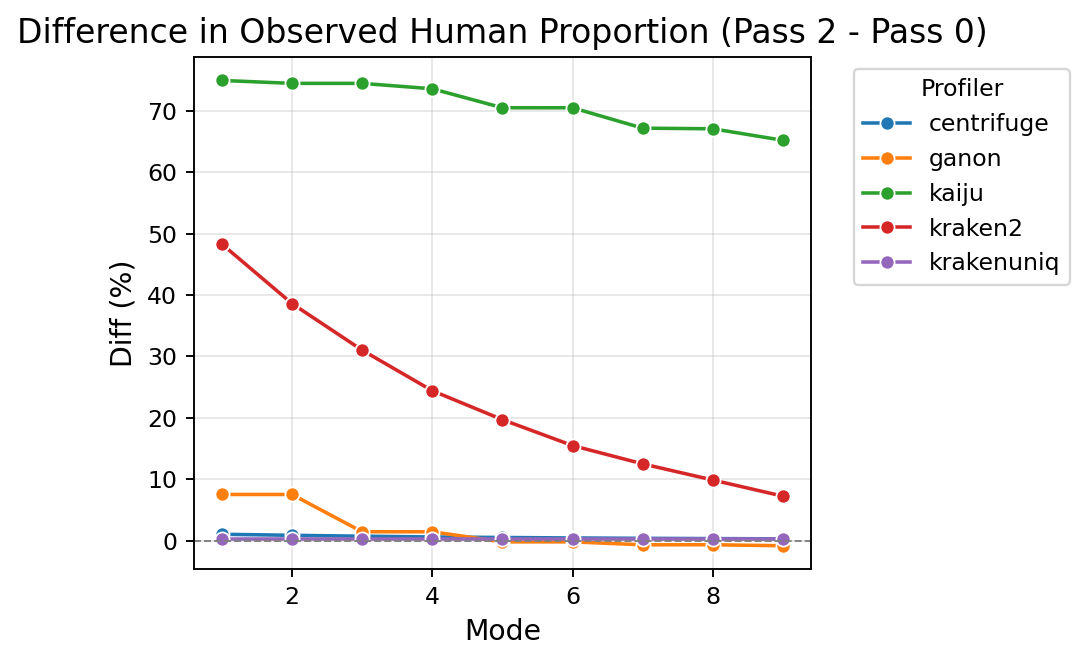

In [8]:
# 1A) Check if there are differences in human read assignment.

# Step 1: Calculate the differences between pass 2 and pass 0 for each profiler and mode

pass_diff = (
    df_host_profile_info_artificial.pivot_table(
        index=["profiler", "mode"], columns="pass", values="observed_human_prop"
    )
    .reset_index()
)

# Ensure column names are integers
pass_diff.columns.name = None  # Remove the columns' name from pivot_table
pass_diff.columns = ['profiler', 'mode', 0, 2]  # Explicitly rename columns

# Calculate the difference
pass_diff["difference"] = 100 * (pass_diff[2] - pass_diff[0])



# Step 2: Plot the differences using a lineplot

plt.figure(figsize=(6, 4))
sns.lineplot(
    data=pass_diff,
    x="mode",
    y="difference",
    hue="profiler",
    marker="o",
    palette="tab10",
)

plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.title("Difference in Observed Human Proportion (Pass 2 - Pass 0)", fontsize=14)
plt.xlabel("Mode", fontsize=12)
plt.ylabel("Diff (%)", fontsize=12)

plt.grid(alpha=0.3)

plt.legend(title="Profiler", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()

plt.show()

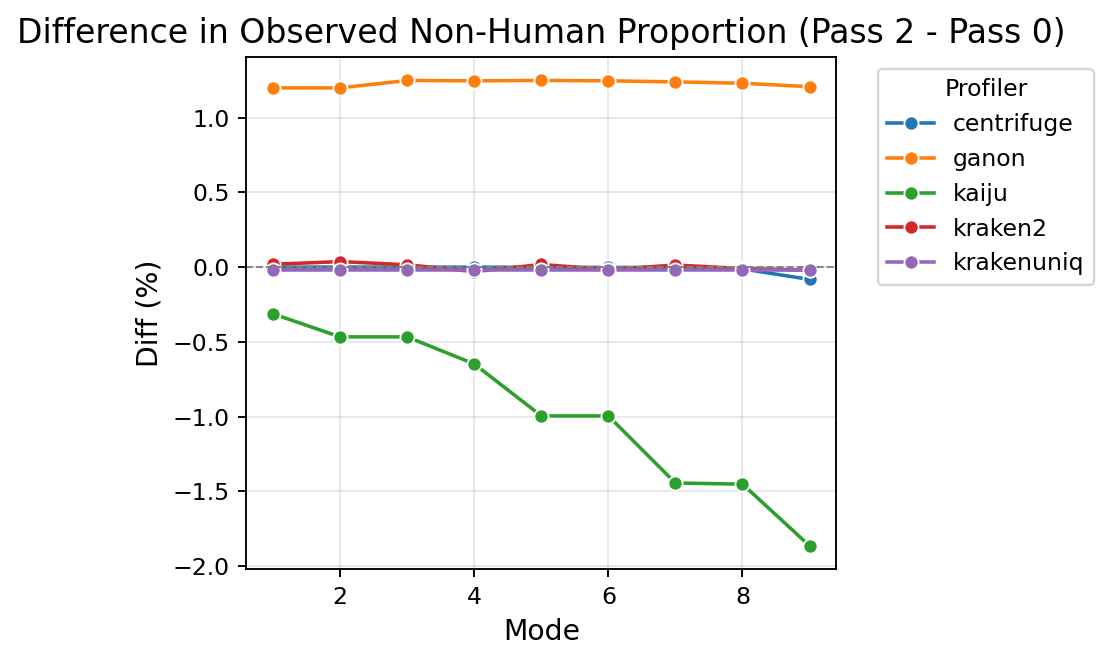

In [9]:
# 1B) Check if there are differences in non-human read assignment.

pass_diff = (
    df_host_profile_info_artificial.pivot_table(
        index=["profiler", "mode"], columns="pass", values="observed_others_prop"
    )
    .reset_index()
)

pass_diff["difference"] = 100 * (pass_diff[2] - pass_diff[0])



# Step 2: Plot the differences using a lineplot

plt.figure(figsize=(6, 4))
sns.lineplot(
    data=pass_diff,
    x="mode",
    y="difference",
    hue="profiler",
    marker="o",
    palette="tab10",
)

plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.title("Difference in Observed Non-Human Proportion (Pass 2 - Pass 0)", fontsize=14)
plt.xlabel("Mode", fontsize=12)
plt.ylabel("Diff (%)", fontsize=12)

plt.grid(alpha=0.3)

plt.legend(title="Profiler", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()

plt.show()

**What do we see here?**
- The number of reads assigned to humans without host mapping is very variable depending on the profiler. Centrifuge, krakenuniq and ganon and map human reads correctly, whereas kaiju, kraken2 fail to map the reads to human. The differences tend to decrease with the sensitivity mode, that is, paradoxically, a more strict read assignment leads to an improved number of human-mapped reads. However, this makes sense because more reads are assigned in general, and thus both human and non-human reads are mapped.
- However, this difference does not occur in non-human species. In general, non-human species are assigned equally with or without host mapping. This is interesting because we would expect a higher amount of reads assigned to non-human species originating from a false positive assignment of human reads, but seems not to be the case, even in profilers that have a high ammount of unmapped human reads.
    - Still, we have to take into acount that the profiler databases include a host mapping step.


In [10]:
table_artificial_taxcounts = pd.read_csv('../../src/version_2/table_artificial_taxid.csv', sep=';', names=['species', 'taxid', 'count'])
table_artificial_taxcounts = table_artificial_taxcounts[table_artificial_taxcounts['taxid'] != 9606]
table_artificial_taxcounts['abundance'] = 100 * table_artificial_taxcounts['count'] / table_artificial_taxcounts['count'].sum()
table_artificial_taxcounts

species    taxid   count  abundance
1               Cutibacterium acnes     1747  312500      3.125
2         Lactobacillus acidophilus     1579  312500      3.125
3           Bifidobacterium bifidum     1681  312500      3.125
4           Akkermansia muciniphila   239935  312500      3.125
5                 Blautia coccoides     1532  312500      3.125
6                      Blautia luti    89014  312500      3.125
7                Bacteroides ovatus    28116  312500      3.125
8          Bacteroides intestinalis   329854  312500      3.125
9              Bacteroides fragilis      817  312500      3.125
10                 Escherichia coli   511145  312500      3.125
11                    Dietzia lutea   546160  250000      2.500
12  Ruthenibacterium lactatiformans  1550024  187500      1.875
13     Faecalibacterium prausnitzii      853  187500      1.875
14       Parabacteroides distasonis      823  187500      1.875
15           Parabacteroides merdae    46503  187500      1.875
16  Fusicatenibacter saccharivorans  1150298  187500      1.875
17   Erysipelatoclostridium ramosum     1547  125000      1.250
18         Streptococcus salivarius     1304  125000      1.250
19             Hungatella hathewayi   154046   62500      0.625
20             Eisenbergiella porci  2652274   62500      0.625
21           Butyricimonas faecalis  2093856   62500      0.625
22           Alistipes indistinctus   626932   62500      0.625
23             Alistipes finegoldii   214856   62500      0.625
24           Eubacterium callanderi    53442   62500      0.625
25        Acidaminococcus intestini   187327   62500      0.625
26           Aspergillus chevalieri   182096  200000      2.000
27               Aspergillus flavus     5059  200000      2.000
28         Saccharomyces cerevisiae     4932  200000      2.000
29       Saccharomyces kudriavzevii   114524  200000      2.000
30            Saccharomyces mikatae   114525  200000      2.000
31                 Candida albicans     5476  200000      2.000
32             Candida dubliniensis    42374  200000      2.000
33            Candida orthopsilosis   273371  200000      2.000
34             Malassezia restricta    76775  150000      1.500
35                 Alternaria dauci    48095  150000      1.500
36            Kazachstania africana   432096  100000      1.000
37            Penicillium digitatum    36651  100000      1.000
38              Pichia kudriavzevii     4909   50000      0.500
39           Trichoderma asperellum   101201   50000      0.500
40           Akanthomyces muscarius  2231603   50000      0.500
41              Fusarium falciforme   195108   50000      0.500
42          Eremothecium sinecaudum    45286   50000      0.500
43          Cryptococcus decagattii  1859122   50000      0.500
44          Kwoniella shandongensis  1734106   50000      0.500
45               Puccinia triticina   208348   50000      0.500
46             Tobacco mosaic virus    12242  250000      2.500
47                      Rotavirus A    28875  250000      2.500
48                      Rotavirus B    28876  250000      2.500
49                      Rotavirus C    36427  250000      2.500
50                 Bacteriophage P2    10679  200000      2.000
51             Escherichia phage T4    10665  200000      2.000
52   Human immunodeficiency virus 1    11676  200000      2.000
53               Human adenovirus 7   108098  150000      1.500
54                Hepatitis C virus  3052230  150000      1.500
55        Bovine alphaherpesvirus 2  3050244  150000      1.500
56       Human herpesvirus 4 type 2  3050299  150000      1.500
57                 Mimivirus terra2  1128151  100000      1.000
58                     Dengue virus  3052464  100000      1.000
59                     Norovirus GI    11983   50000      0.500
60                 Zaire ebolavirus  3052462   50000      0.500

# Computing detection stats to aswer the questions

One of the parameters used during profiling is the mode of the profilers. Each profiler has a different set of parametters to include reads as valid or not. This may results in the detection of false positives and negatives. 

Here, we are going to study this effect in *in silico* samples to see if there are major changes. We are can measure the effectivity of several variables: 
- Categorical values: we can use each of the columns in the flag system to check how well were species assigned. We can use the precision (TP/TP + FP), recall (TP/TP+FN) and F1-score (2 x precision x recall / precision + recall) and Cohen's kappa.
$$\kappa = \frac{p_0-p_e}{1-p_e} \quad p_0 = \frac{TP + TN}{TP + FP + FN + TN} \quad p_e=\frac{TP + FP}{TP + FP + FN + TN}\cdot\frac{TP + FN }{TP + FP + FN + TN} + \frac{TN + FP}{TP + FP + FN + TN}\cdot\frac{TN + FN}{TP + FP + FN + TN}$$

- Numerical values: we can use the normalized value and the abundance to see how well are reads classified. For that we can use the expected number of reads and abundance. With that we will calculate the (1) difference between observed and expected categories and (2) the mean error and the (3) mean absolute error:
$$(1) \qquad DIFF_i = 100\cdot\frac{x_{obs,i} - x_{exp,i}}{x_{exp,i}}$$ 
$$(2) \qquad ME = E[DIFF_i] = \frac{100}{N}\sum\frac{x_{obs,i} - x_{exp,i}}{x_{exp,i}}$$ 
$$(3A) \qquad MAE = E[|DIFF_i|] = \frac{100}{N}\sum\frac{|x_{obs,i} - x_{exp,i}|}{x_{exp,i}}$$ 
$$(3B) \qquad MAED = \sigma[|DIFF_i|]$$ 
- For numerical values we are also going to calculate the pearson correlation between the observed and expected values, using a log10(1+x) transform

## Categorical values

In [11]:
def calculate_nominal_metrics(df_tax_ground_truth, df_flags_observed, column):
    list_expected_taxids = list(df_tax_ground_truth['taxid'].astype(int).values)
    list_observed_true_taxids = list(df_flags_observed.loc[df_flags_observed[column] == False, 'taxonomy_id'].astype(int).values)
    list_observed_false_taxids = list(df_flags_observed.loc[df_flags_observed[column] == True, 'taxonomy_id'].astype(int).values)

    TP = len([i for i in list_expected_taxids if i in list_observed_true_taxids])
    FN = len([i for i in list_expected_taxids if i not in list_observed_true_taxids])
    FP = len([i for i in list_observed_true_taxids if i not in list_expected_taxids])
    TN = len([i for i in list_observed_false_taxids if i not in list_expected_taxids])

    assert len(set(list_expected_taxids + list_observed_true_taxids + list_observed_false_taxids)) == TP + FN + FP + TN

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    try:
        f1 = (2 * precision * recall) / (precision + recall)
    except:
        f1 = 0
    
    # Create kappa measures
    ALL = TP + FN + FP + TN
    p0 = (TP + TN) / (ALL)
    pe = (TP + FP)/ALL * (TP + FN)/ALL + (TN + FP)/ALL * (TN + FN)/ALL
    kappa = (p0 - pe) / (1 - pe)

    return precision, recall, f1, kappa, TP, FN, FP, TN



In [12]:
columns_selected = ['centrifuge_norm', 'ganon_norm', 'kaiju_norm', 'kmcp_norm', 'kraken2_norm', 'krakenuniq_norm',
                    'centrifuge_relab', 'ganon_relab', 'kaiju_relab', 'kmcp_relab', 'kraken2_relab', 'krakenuniq_relab',
                    'mean_norm', 'CV_norm', 'mean_relab', 'CV_relab']
df_nominal_stats = {'pass': [], 'mode': [], 'S': [], 'column': [], 'precision': [], 'recall': [], 'f1': [], 
                    'kappa': [], 'TP|FN|FP|TN': []}

for passn in [0, 2]:
    for mode in range(1, 10):
        for S in [0, 1, 2, 3, 4, 5, 6, 7, 10, 15]:
            for column in columns_selected: 
                summary_table_flags = pd.read_csv(f'{RESULTS_DIR}/summary/ARTIFICIAL_pass{passn}_mode{mode}_taxspecies_S{S}.flags.tsv', sep='\t')
                try:
                    precision, recall, f1, kappa, TP, FN, FP, TN = calculate_nominal_metrics(table_artificial_taxcounts, summary_table_flags, column)
                except KeyError:
                    continue 

                df_nominal_stats['pass'].append(passn)
                df_nominal_stats['mode'].append(mode)
                df_nominal_stats['S'].append(S)
                df_nominal_stats['column'].append(column)

                df_nominal_stats['precision'].append(precision)
                df_nominal_stats['recall'].append(recall)
                df_nominal_stats['f1'].append(f1)
                df_nominal_stats['kappa'].append(kappa)
                df_nominal_stats['TP|FN|FP|TN'].append((TP, FN, FP, TN))

df_nominal_stats = pd.DataFrame(df_nominal_stats)

In [13]:
df_nominal_stats

pass  mode   S            column  precision  recall    f1  kappa  \
0        0     1   0   centrifuge_norm      1.000   0.050 0.095  0.094   
1        0     1   0        ganon_norm      0.833   0.083 0.152  0.149   
2        0     1   0        kaiju_norm      1.000   0.100 0.182  0.179   
3        0     1   0      kraken2_norm      1.000   0.217 0.356  0.352   
4        0     1   0   krakenuniq_norm      1.000   0.100 0.182  0.179   
...    ...   ...  ..               ...        ...     ...   ...    ...   
2515     2     9  15  krakenuniq_relab      0.400   0.967 0.566  0.563   
2516     2     9  15         mean_norm      0.310   0.967 0.470  0.466   
2517     2     9  15           CV_norm      0.005   0.900 0.009 -0.000   
2518     2     9  15        mean_relab      0.258   0.967 0.407  0.402   
2519     2     9  15          CV_relab      0.005   0.933 0.009 -0.000   

              TP|FN|FP|TN  
0        (3, 57, 0, 3637)  
1        (5, 55, 1, 3636)  
2        (6, 54, 0, 3637)  
3       (13, 47, 0, 3637)  
4        (6, 54, 0, 3637)  
...                   ...  
2515   (58, 2, 87, 12282)  
2516  (58, 2, 129, 12240)  
2517  (54, 6, 11726, 643)  
2518  (58, 2, 167, 12202)  
2519  (56, 4, 11731, 638)  

[2520 rows x 9 columns]

## Numerical values

In [14]:
def compute_mad(values):
    median = np.median(values)
    mad = np.median(np.abs(values - median))
    return mad

def calculate_numerical_metrics(df_tax_ground_truth, df_counts_observed, profiler, suffix):
    df_tax_ground_truth = df_tax_ground_truth.copy().set_index('taxid')
    df_counts_observed = df_counts_observed.copy().set_index('taxonomy_id')

    list_expected_taxids = df_tax_ground_truth.index.astype(int).values
    list_observed_true_taxids = df_counts_observed.index.astype(int).values

    combined_taxid = np.intersect1d(list_expected_taxids, list_observed_true_taxids)
    species = df_tax_ground_truth.loc[combined_taxid, 'species'].values
    observed_counts = df_counts_observed.loc[combined_taxid, f'{profiler}_{suffix}'].fillna(0).values

    expected_col = 'count' if suffix == 'norm' else 'abundance'
    expected_counts = df_tax_ground_truth.loc[combined_taxid, expected_col].values

    diff_counts = 100 * (observed_counts - expected_counts) / expected_counts

    ME_counts = np.mean(diff_counts)
    MAE_counts = np.mean(np.abs(diff_counts))
    MAED_counts = np.std(np.abs(diff_counts))
    MACV_counts = MAED_counts / MAE_counts

    if len(combined_taxid) > 35:
        x,y = expected_counts, observed_counts 

        slope, _, r_value, _, _ = linregress(x, y)
        r2 = r_value ** 2
    else:
        slope, r2 = np.nan, np.nan

    return diff_counts, ME_counts, MAE_counts, MAED_counts, MACV_counts, slope, r2, combined_taxid, species, expected_counts, observed_counts


In [15]:
df_numerical_stats = {'pass': [], 'mode': [], 'profiler': [], 
                    'diff_counts': [], 'ME_counts': [], 'MAE_counts': [], 'MAED_counts': [], 'MACV_counts': [], 
                    'corr_counts': [], 'R2_counts': [], 'taxid_counts': [], 
                    'species_counts': [], 'expected_counts': [], 'observed_counts': [], 
                    'diff_abundance': [], 'ME_abundance': [], 'MAE_abundance': [], 'MAED_abundance': [], 'MACV_abundance': [], 
                    'corr_abundance': [], 'R2_abundance': [], 'taxid_abundance': [], 
                    'species_abundance': [], 'expected_abundance': [], 'observed_abundance': [],  }

for passn in [0, 2]:
    for mode in range(1, 10):
            for profiler in LIST_PROFILERS + ['mean']: 
                summary_table_flags = pd.read_csv(f'{RESULTS_DIR}/summary/ARTIFICIAL_pass{passn}_mode{mode}_taxspecies_S{S}.flags.tsv', sep='\t')
                summary_table_counts = pd.read_csv(f'{RESULTS_DIR}/summary/ARTIFICIAL_pass{passn}_mode{mode}_taxspecies_S{S}.diversity.tsv', sep='\t')
                try:
                    diff_counts, ME_counts, MAE_counts, MAED_counts, MACV_counts, corr_counts, rmse_counts, taxids_counts, species_counts, expected_counts, observed_counts = \
                        calculate_numerical_metrics(table_artificial_taxcounts, summary_table_counts, \
                                                                        profiler, suffix='norm')
                    diff_abundance, ME_abundance, MAE_abundance, MAED_abundance, MACV_abundance, corr_abundance, rmse_abundance, taxids_abundance, species_abundance, expected_abundance, observed_abundance = \
                        calculate_numerical_metrics(table_artificial_taxcounts, summary_table_counts, \
                                                                        profiler, suffix='relab')
                except KeyError:
                    raise
                    continue 
                
                df_numerical_stats['pass'].append(passn)
                df_numerical_stats['mode'].append(mode)
                df_numerical_stats['profiler'].append(profiler)

                df_numerical_stats['diff_counts'].append(diff_counts)
                df_numerical_stats['ME_counts'].append(ME_counts)                
                df_numerical_stats['MAE_counts'].append(MAE_counts)                
                df_numerical_stats['MAED_counts'].append(MAED_counts)                
                df_numerical_stats['MACV_counts'].append(MACV_counts)                
                df_numerical_stats['corr_counts'].append(corr_counts)                
                df_numerical_stats['R2_counts'].append(rmse_counts) 
                df_numerical_stats['taxid_counts'].append(taxids_counts)
                df_numerical_stats['species_counts'].append(species_counts)
                df_numerical_stats['expected_counts'].append(expected_counts)
                df_numerical_stats['observed_counts'].append(observed_counts)

                df_numerical_stats['diff_abundance'].append(diff_abundance)
                df_numerical_stats['ME_abundance'].append(ME_abundance)
                df_numerical_stats['MAE_abundance'].append(MAE_abundance)
                df_numerical_stats['MAED_abundance'].append(MAED_abundance)
                df_numerical_stats['MACV_abundance'].append(MACV_abundance)
                df_numerical_stats['corr_abundance'].append(corr_abundance)                
                df_numerical_stats['R2_abundance'].append(rmse_abundance) 
                df_numerical_stats['taxid_abundance'].append(taxids_abundance)
                df_numerical_stats['species_abundance'].append(species_abundance)
                df_numerical_stats['expected_abundance'].append(expected_abundance)
                df_numerical_stats['observed_abundance'].append(observed_abundance)

df_numerical_stats = pd.DataFrame(df_numerical_stats)

In [16]:
df_numerical_stats

pass  mode    profiler  \
0       0     1  centrifuge   
1       0     1       ganon   
2       0     1       kaiju   
3       0     1     kraken2   
4       0     1  krakenuniq   
..    ...   ...         ...   
103     2     9       ganon   
104     2     9       kaiju   
105     2     9     kraken2   
106     2     9  krakenuniq   
107     2     9        mean   

                                           diff_counts  ME_counts  MAE_counts  \
0    [-21.76736, -50.1056, -74.39946666666667, -58....    -16.939      17.173   
1    [-23.91328, -55.785066666666665, -83.386666666...    -28.729      28.729   
2    [-53.25664, -79.21386666666666, -91.4437333333...    -49.543      49.543   
3    [-76.07584, -94.63306666666666, -99.4, -99.609...    -65.147      65.147   
4    [-19.62944, -48.239466666666665, -68.408533333...    -16.729      17.018   
..                                                 ...        ...         ...   
103  [3.88512, -35.4976, -56.00053333333334, -32.8,...     -1.882      18.223   
104  [-48.45856, -76.704, -89.0208, -85.9616, -80.8...    -43.474      43.474   
105  [-39.60768, -84.74186666666667, -95.9482666666...    -32.087      32.087   
106  [-19.67168, -48.3264, -68.4816, -54.56, -41.30...    -16.778      17.064   
107  [-20.390584802138655, -49.665829444940506, -66...    -16.259      16.933   

     MAED_counts  MACV_counts  corr_counts  R2_counts  \
0         23.505        1.369        0.635      0.576   
1         21.022        0.732        0.558      0.590   
2         28.481        0.575        0.389      0.313   
3         24.902        0.382        0.176      0.122   
4         23.765        1.396        0.642      0.572   
..           ...          ...          ...        ...   
103       14.940        0.820        0.751      0.659   
104       29.718        0.684        0.422      0.324   
105       35.514        1.107        0.419      0.235   
106       23.782        1.394        0.641      0.572   
107       21.171        1.250        0.638      0.622   

                                          taxid_counts  \
0    [817, 823, 853, 1304, 1532, 1547, 1579, 1681, ...   
1    [817, 823, 853, 1304, 1532, 1547, 1579, 1681, ...   
2    [817, 823, 853, 1304, 1532, 1547, 1579, 1681, ...   
3    [817, 823, 853, 1304, 1532, 1547, 1579, 1681, ...   
4    [817, 823, 853, 1304, 1532, 1547, 1579, 1681, ...   
..                                                 ...   
103  [817, 823, 853, 1304, 1532, 1547, 1579, 1681, ...   
104  [817, 823, 853, 1304, 1532, 1547, 1579, 1681, ...   
105  [817, 823, 853, 1304, 1532, 1547, 1579, 1681, ...   
106  [817, 823, 853, 1304, 1532, 1547, 1579, 1681, ...   
107  [817, 823, 853, 1304, 1532, 1547, 1579, 1681, ...   

                                        species_counts  \
0    [Bacteroides fragilis, Parabacteroides distaso...   
1    [Bacteroides fragilis, Parabacteroides distaso...   
2    [Bacteroides fragilis, Parabacteroides distaso...   
3    [Bacteroides fragilis, Parabacteroides distaso...   
4    [Bacteroides fragilis, Parabacteroides distaso...   
..                                                 ...   
103  [Bacteroides fragilis, Parabacteroides distaso...   
104  [Bacteroides fragilis, Parabacteroides distaso...   
105  [Bacteroides fragilis, Parabacteroides distaso...   
106  [Bacteroides fragilis, Parabacteroides distaso...   
107  [Bacteroides fragilis, Parabacteroides distaso...   

                                       expected_counts  \
0    [312500, 187500, 187500, 125000, 312500, 12500...   
1    [312500, 187500, 187500, 125000, 312500, 12500...   
2    [312500, 187500, 187500, 125000, 312500, 12500...   
3    [312500, 187500, 187500, 125000, 312500, 12500...   
4    [312500, 187500, 187500, 125000, 312500, 12500...   
..                                                 ...   
103  [312500, 187500, 187500, 125000, 312500, 12500...   
104  [312500, 187500, 187500, 125000, 312500, 12500...   
105  [312500, 187500, 187500, 125000, 312500, 12500...   


## Analysis of kappa/F1

F1-score and $\kappa$ are quite different measures but we observe that they are correlated in this data.

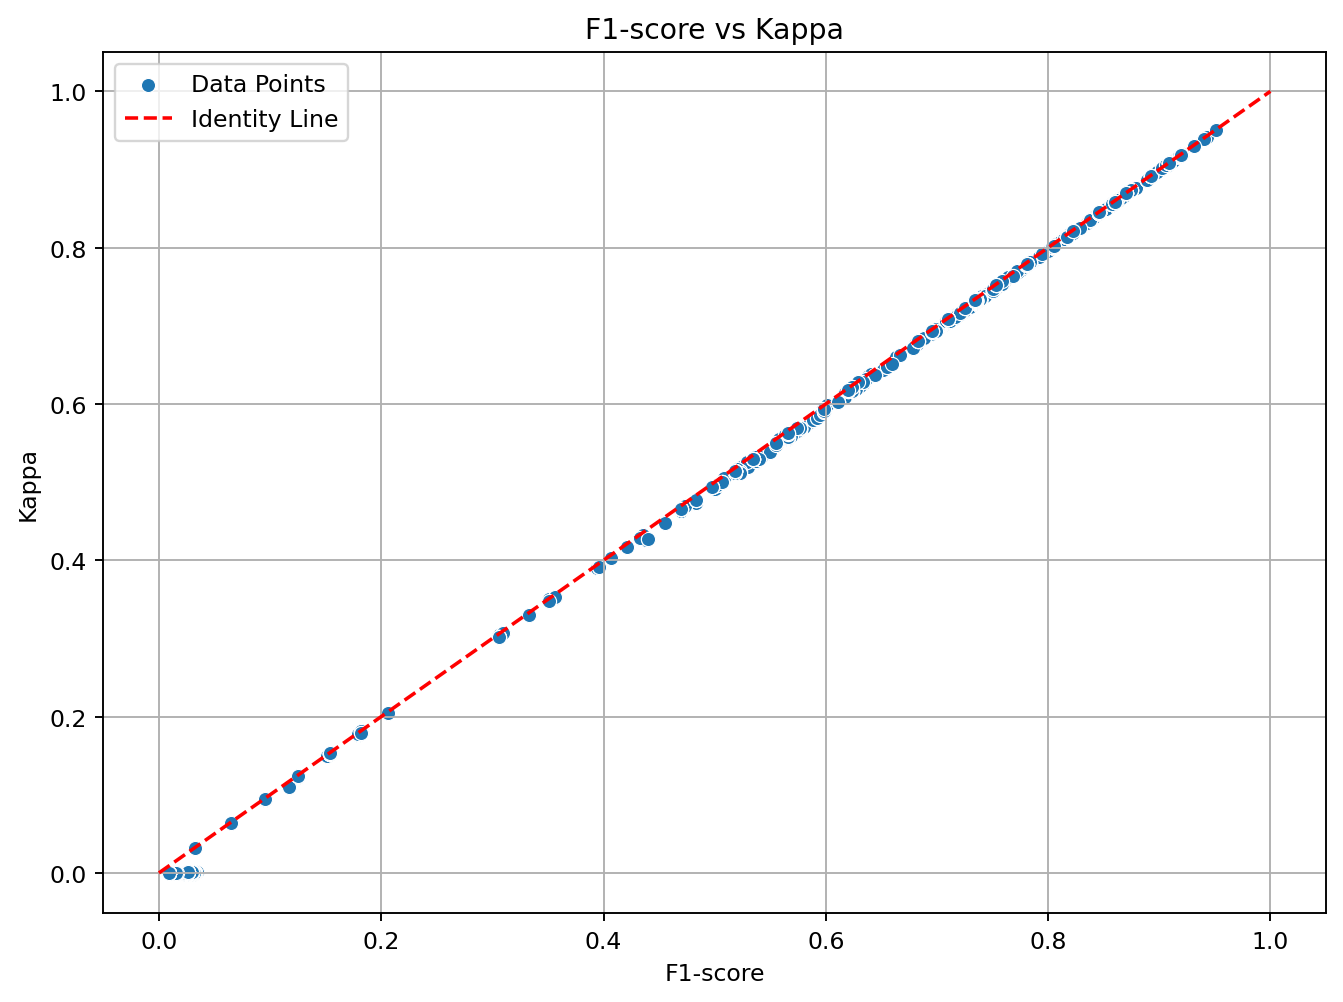

Pearson correlation between F1 and Kappa: 0.9997826111567193


In [17]:
# Scatter plot with the identity line
plt.figure(figsize=(8, 6))
sns.scatterplot(x='f1', y='kappa', data=df_nominal_stats, label='Data Points')

# Add the identity line (y = x)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Identity Line')

# Add title and labels
plt.title('F1-score vs Kappa')
plt.xlabel('F1-score')
plt.ylabel('Kappa')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Compute and print correlation (Pearson by default)
corr = df_nominal_stats['f1'].corr(df_nominal_stats['kappa'])
print("Pearson correlation between F1 and Kappa:", corr)

In that sense, we can then use one of the measures to explain the results and don't need the second one. We are going to select the F1 score because it has a more clear interpretability and it is related to precision and recall, which are alrady being used.

# How does the S parametter used during curve fitting affect?

The S parametter is useful to tweak the detection results, so that we can include more or less species during the flagging step. Since it is a structural parametter, we want to fit it first so that we can answer several other comparisons.

To do this we are going to use the nominal variables and their derived statistics.


## Checking recall/precision/F1-score for inclusion/exclusion of species

In [18]:
cols = [f'{i}_norm' for i in LIST_PROFILERS] + ['mean_norm']
modes = range(2, 9)
passn = [2]
S_values = df_nominal_stats['S'].unique()

In [19]:
subset_df = df_nominal_stats[(df_nominal_stats['pass'].isin(passn)) & \
                             (df_nominal_stats['column'].isin(cols)) & \
                              (df_nominal_stats['mode'].isin(modes))]

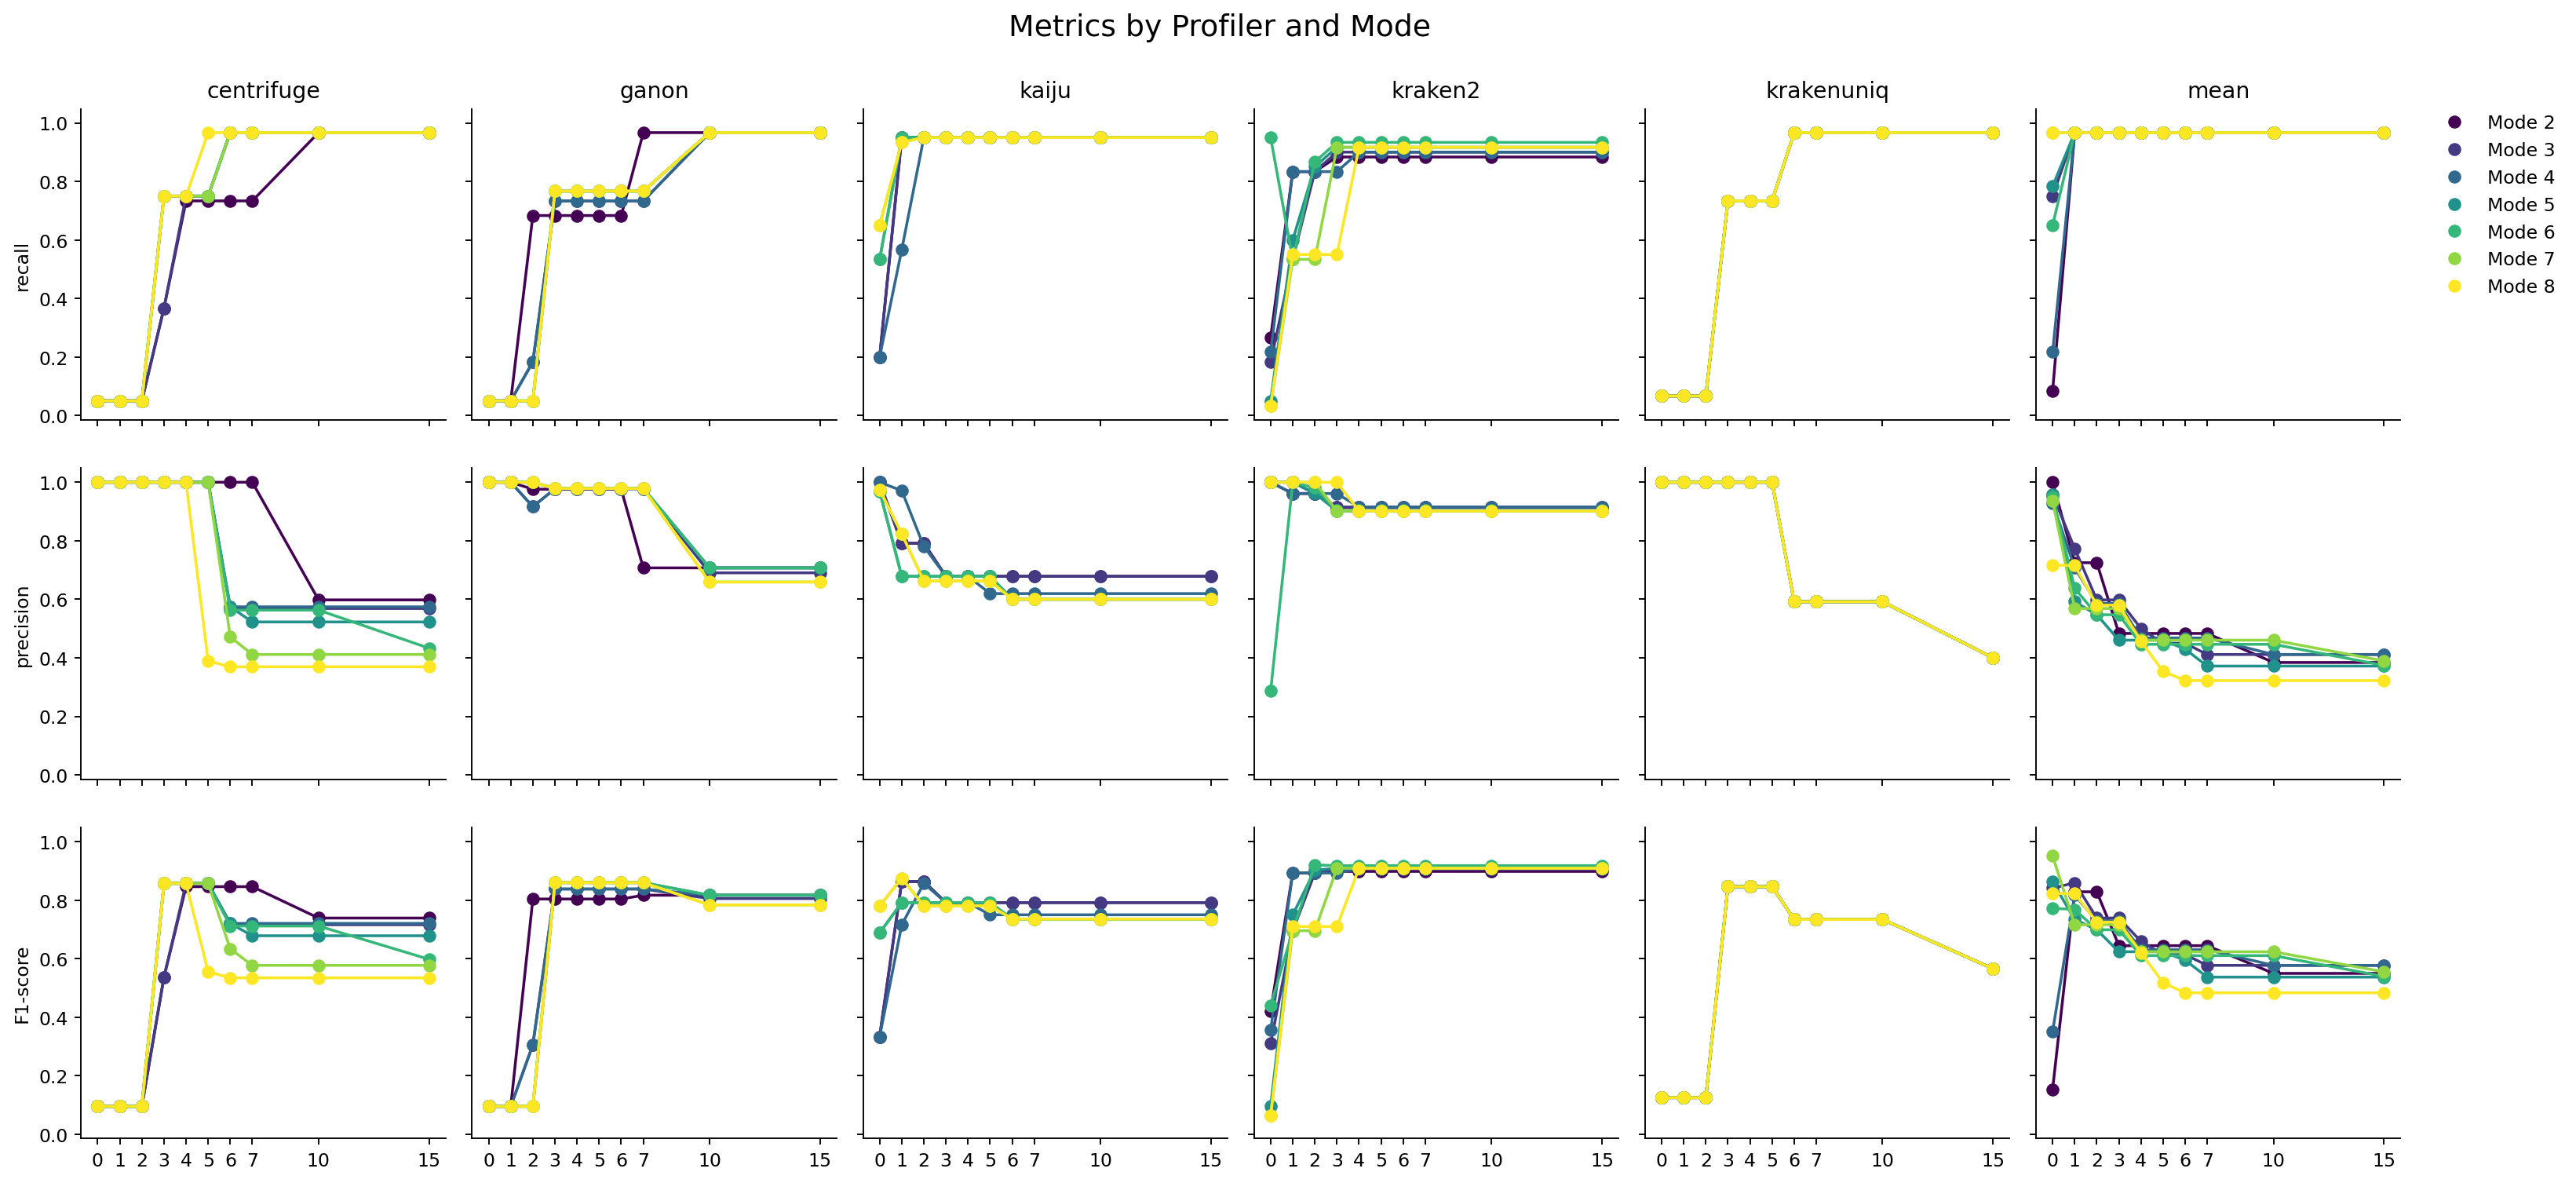

In [20]:
melted_df = pd.melt(
    subset_df,
    id_vars=['mode', 'S', 'column'],
    value_vars=['recall', 'precision', 'f1'],
    var_name='metric',
    value_name='score'
)

# Create a colormap for 'mode'
norm = Normalize(vmin=melted_df['mode'].min(), vmax=melted_df['mode'].max())
cmap = plt.cm.viridis  # Choose a colormap (e.g., 'viridis', 'plasma', 'cividis')

# Create a FacetGrid: 6x3 grid (row for each profiler, column for each metric)
g = sns.FacetGrid(
    melted_df, 
    col='column', 
    row='metric', 
    height=3, 
    sharey=True, 
    sharex=True
)

# Map the lineplot to the grid
def lineplot_with_cmap(data, **kwargs):
    for mode in sorted(data['mode'].unique()):
        subset = data[data['mode'] == mode]
        plt.plot(subset['S'], subset['score'], label=f"Mode {mode}",
                 color=cmap(norm(mode)), marker='o')

g.map_dataframe(lineplot_with_cmap)

# Create a legend for the discrete modes
handles = [
    plt.Line2D([0], [0], color=cmap(norm(mode)), marker='o', linestyle='', label=f"Mode {mode}")
    for mode in sorted(melted_df['mode'].unique())
]
plt.legend(
    handles=handles, 
    title="", 
    bbox_to_anchor=(1.05, 3), 
    loc='center left', 
    frameon=False
)

# Set x-axis ticks (if you have specific S values)
g.set(xticks=subset_df['S'].unique())

for ax in g.axes.ravel():
    ax.set_title('')

# Add axis labels and titles
for ax, profiler in zip(g.axes[0, :], melted_df['column'].unique()):
    ax.set_title(profiler.replace('_norm', ''))

for ax, score in zip(g.axes[:, 0], ['recall', 'precision', 'F1-score']):
    ax.set_ylabel(score)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Metrics by Profiler and Mode", fontsize=16)

plt.show()

/home/alex/Programs/miniconda3/envs/EVs/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


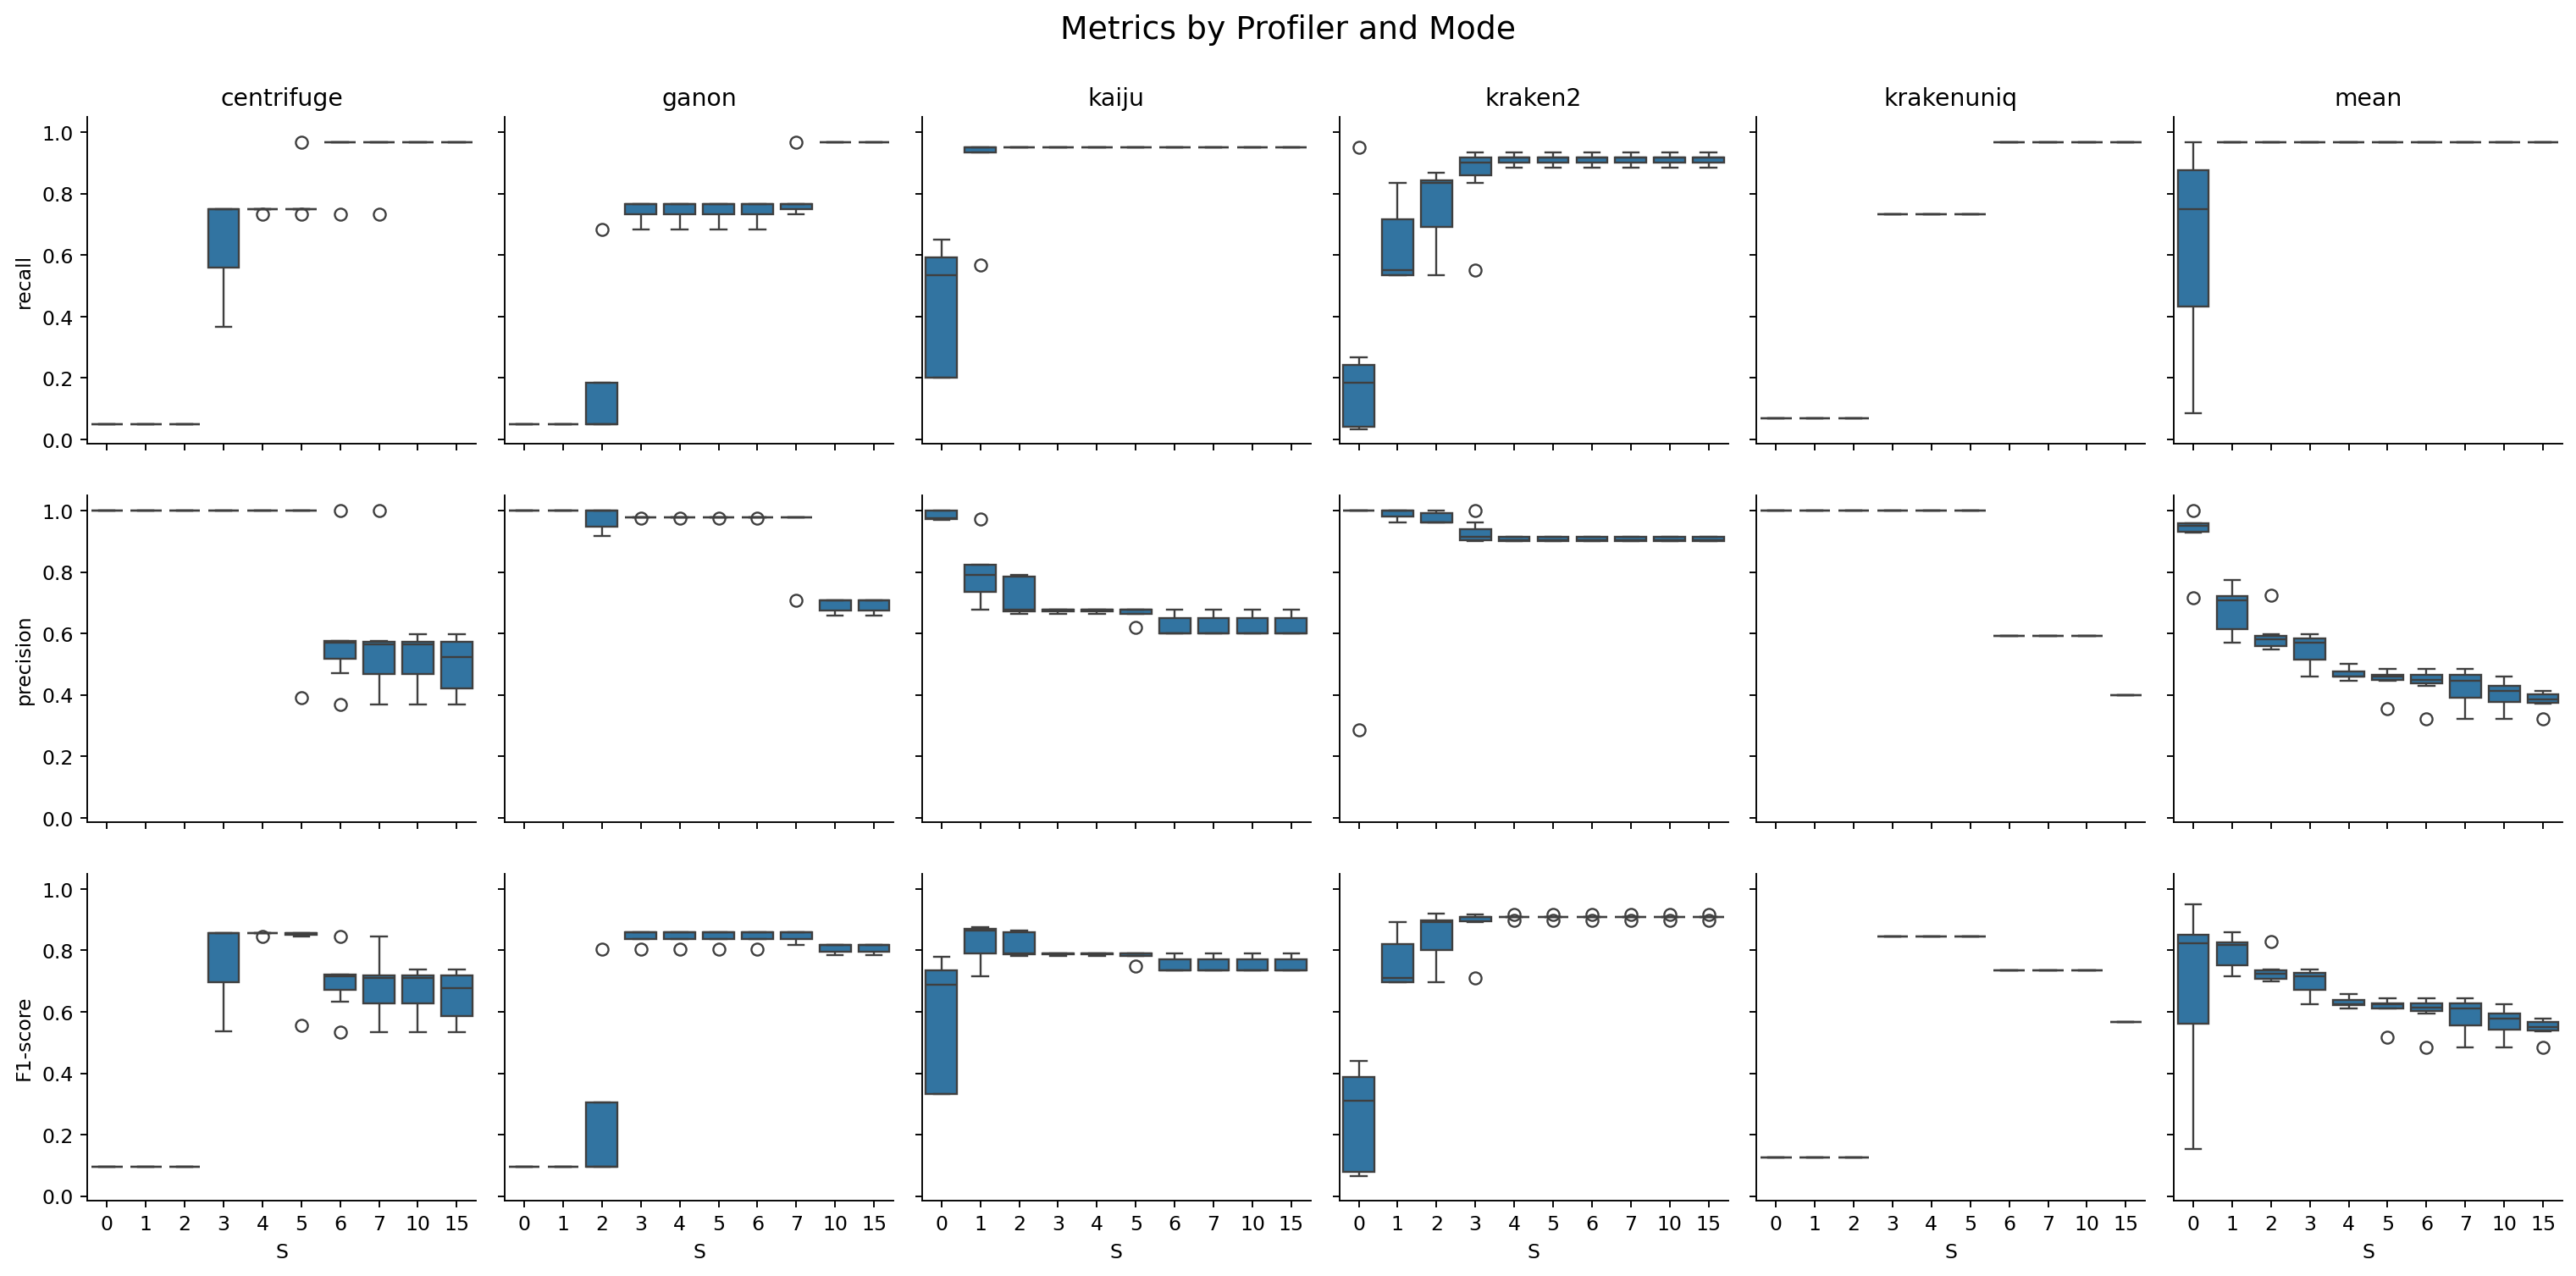

In [21]:
g = sns.FacetGrid(
    melted_df, 
    col='column', 
    row='metric', 
    height=3, 
    sharey=True, 
    sharex=True
)

g.map(sns.boxplot, 'S', 'score')

# Set x-axis ticks (if you have specific S values)
for ax in g.axes.ravel():
    ax.set_title('')

# Add axis labels and titles
for ax, profiler in zip(g.axes[0, :], melted_df['column'].unique()):
    ax.set_title(profiler.replace('_norm', ''))

for ax, score in zip(g.axes[:, 0], ['recall', 'precision', 'F1-score']):
    ax.set_ylabel(score)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Metrics by Profiler and Mode", fontsize=16)

plt.show()

The aim of this part of the analysis was to select the "optimal" `S` to then make other comparisons and extract proper conclusions. 
If we look at individual profilers, the aim is not the select the `S` with best F1 score, but to select the smallest `S` that provides a sufficiently high recall, ensuring that we don't lose TP species. This threshold depends on the profiler. For CEN it is 6-7, GAN is 7-10, KAI is 1-2, KR2 is 4-5, KRU is 5-6. We see that at these values the precision drops (expectedly), but it remains stable afterwards for most profilers. Therefore, a value of `S=2` should be sufficient to ensure that the results are correct. 

**IMPORTANT**: conceptually, if we are choosng the number of the species based on the mean number of reads, using a low `S` is still good, because the number of reads reported by profilers that are not flagged are still considered. That is, the # of reads assigned to one profiler is the same regardless of S. 

The advantage of using the mean value instead of the individual profilers is that it tends to retrieve a better stability on the precision throughout the S values and modes. In fact, each profiler has an individual dinamic, and the mean value averages them all. Therefore, using the averaged value for `S` allows us to choose the parameter with better predictability, ensuring that we don't choose a very high value, while at the same time keeping the correct number of reads.

Therefore, we are going to choose `S=2` and `S=7` for comparisons of robustness with biological samples. 

#  Does pass0/pass2 (no host pre-mapping vs host pre-mapping) affect the detection of the species?

For this part we are going to run run analyses:
- Retrieve the raw detection of species with the passes, and calculate their jaccard index.
- Calculate $\chi^2$ for each case and see if there are significative differences.
- Calculate the Pearson correlation + RMSE for several mode values.


## Total number of species and Jaccard index

In [22]:
# Plot Jaccard index between the different species

"""
For this part we are going to read all the .standardised.species reports and simply read the number of species and compute a table with the total number of species and the jaccard index
"""

def get_n_species(sample, mode, profiler, S=15):
    pass0_df = pd.read_csv(f'{RESULTS_DIR}/summary/{sample}_pass0_mode{mode}_taxspecies_S{S}.diversity.tsv', sep='\t').set_index('taxonomy_id')
    pass2_df = pd.read_csv(f'{RESULTS_DIR}/summary/{sample}_pass2_mode{mode}_taxspecies_S{S}.diversity.tsv', sep='\t').set_index('taxonomy_id')

    pass0_profiler = pass0_df[profiler].dropna()
    pass2_profiler = pass2_df[profiler].dropna()

    pass0_taxids = pass0_profiler.index.values
    pass2_taxids = pass2_profiler.index.values

    jaccard_index = len(np.intersect1d(pass0_taxids, pass2_taxids)) / len(np.union1d(pass0_taxids, pass2_taxids))

    return len(pass0_taxids), len(pass2_taxids), jaccard_index


dict_n_species = {'profiler': [],
                  'mode': [],
                  'pass 0 species': [],
                  'pass 2 species': [],
                  'jaccard': []}

for profiler in LIST_PROFILERS + ['mean']:
    for mode in range(1,10):
        try:
            pass0_n_species, pass2_n_species, jaccard_index = get_n_species('ARTIFICIAL', mode, profiler + '_norm')
            dict_n_species['profiler'].append(profiler)
            dict_n_species['mode'].append(mode)
            dict_n_species['pass 0 species'].append(pass0_n_species)
            dict_n_species['pass 2 species'].append(pass2_n_species)
            dict_n_species['jaccard'].append(jaccard_index)
        except:
            print(f'No entry added for profiler {profiler} and mode {mode}')

df_n_species = pd.DataFrame(dict_n_species)


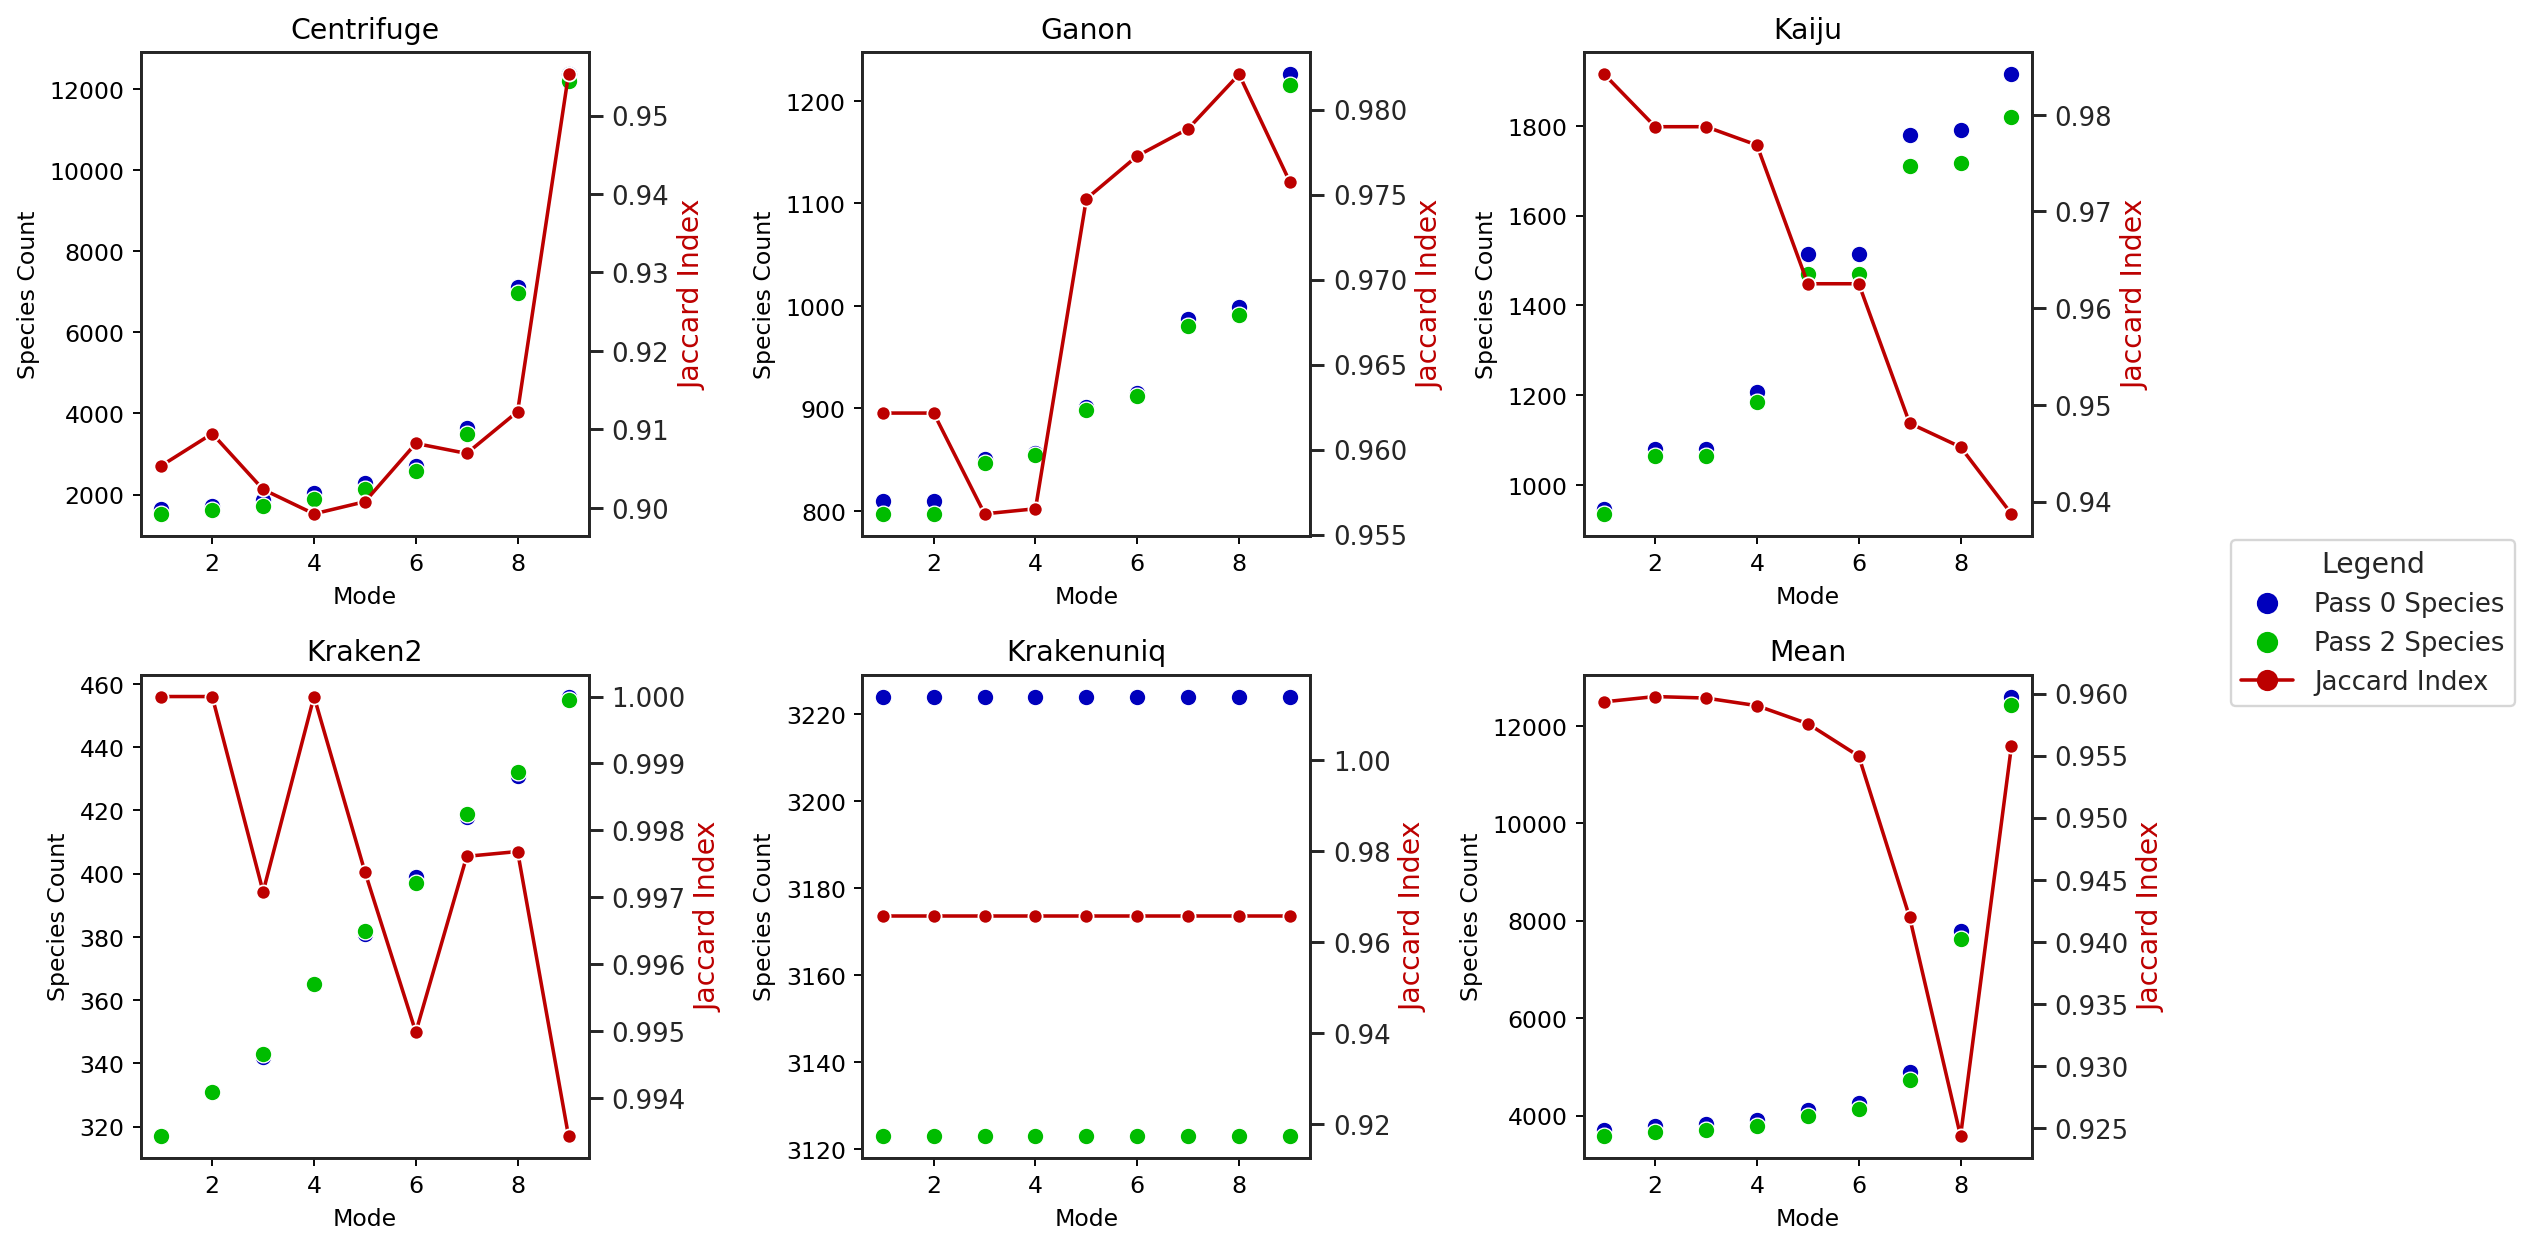

In [23]:
# Initialize a 3x2 grid for subplots
fig, axes = plt.subplots(2, 3, figsize=(13, 7.5))
axes = axes.flatten()

# Set Seaborn style
sns.set_theme(style="white")

# Define custom labels for the shared legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='#0000bc', label='Pass 0 Species', markersize=8, linestyle='None'),
    plt.Line2D([0], [0], marker='o', color='#00bc00', label='Pass 2 Species', markersize=8, linestyle='None'),
    plt.Line2D([0], [0], marker='o', color='#bc0000', label='Jaccard Index', markersize=8, linestyle='-')
]

# Plot for each profiler
for i, profiler in enumerate(LIST_PROFILERS + ['mean']):
    df_profiler = df_n_species[df_n_species['profiler'] == profiler]
    ax1 = axes[i]
    
    # Scatter plots for `pass 0 species` and `pass 2 species`
    sns.scatterplot(
        data=df_profiler, x='mode', y='pass 0 species', ax=ax1, color='#0000bc', s=50
    )
    sns.scatterplot(
        data=df_profiler, x='mode', y='pass 2 species', ax=ax1, color='#00bc00', s=50
    )
    
    sns.set_theme(style="white")
    
    # Configure the primary y-axis
    ax1.set_xlabel('Mode')
    ax1.set_ylabel('Species Count', color='black')
    #ax1.set_yscale('log')  # Optional: Log scale
    ax1.set_title(f'{profiler.capitalize()}')
    
    # Create a secondary y-axis for Jaccard index
    ax2 = ax1.twinx()
    sns.lineplot(
        data=df_profiler, x='mode', y='jaccard', ax=ax2, color='#bc0000', marker='o'
    )
    ax2.set_ylabel('Jaccard Index', color='#bc0000')

# Hide unused axes
for j in range(len(LIST_PROFILERS) + 1, len(axes)):
    axes[j].axis('off')

# Add a shared legend
fig.legend(
    handles=legend_elements, loc='center right', frameon=True, title="Legend", bbox_to_anchor=(1.15, 0.5)
)

plt.tight_layout()
plt.show()

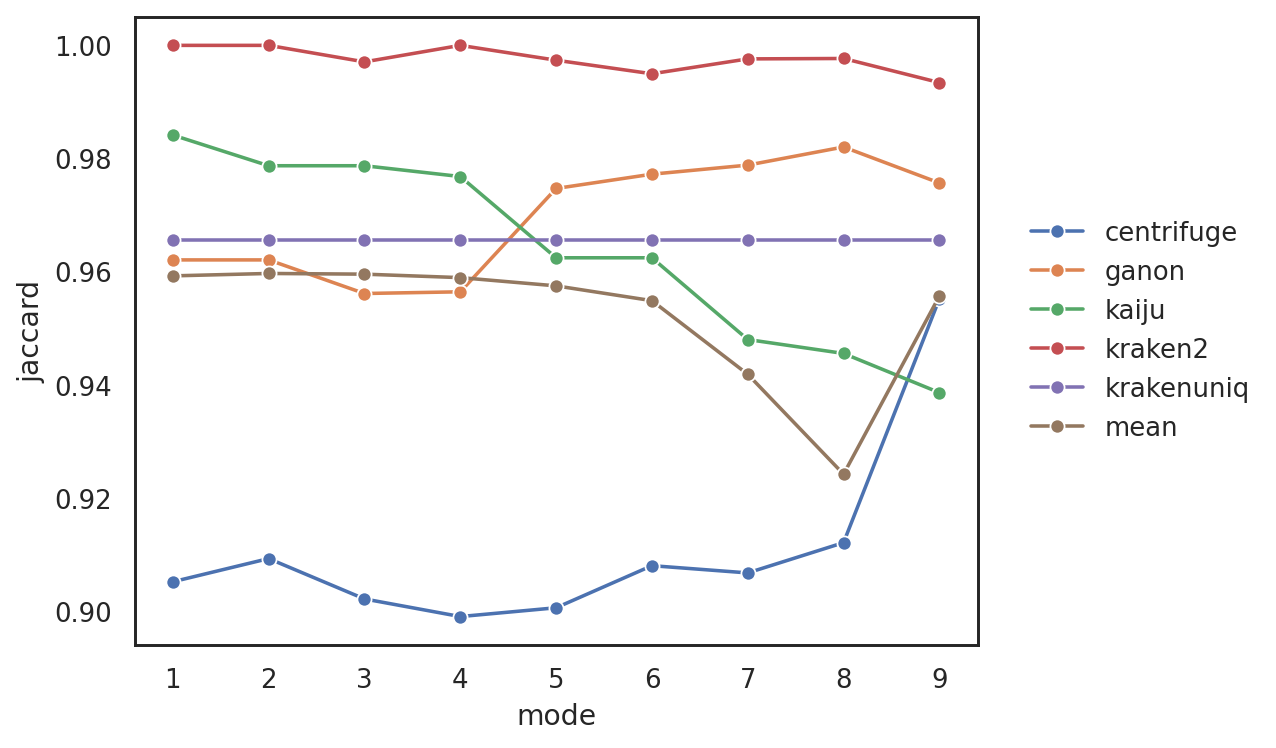

In [24]:
sns.lineplot(df_n_species, x='mode', y='jaccard', hue='profiler', marker='o')
plt.legend(
    loc='center right', frameon=False, bbox_to_anchor=(1.35, 0.5)
)

The number of detected species tends to go up with the mode, which is expected (with the exception of krakenuniq). For most profilers the increase is linear, but for centrifuge the increase is exponential, although it may reach the top of detected species at some point.

We see that in general Jaccard indexes are very high. We should consider that this plot is not "strictly" relevant because many, many species are false positive, so we don't really care about the number of falsely assigned species. Still, it is important to note that pass does not have, grosso modo, a relevant impact. It is interesting to find that for kaiju and centrifuge the mode has an impact. For Kaiju it decreases; this it might be because the number of spurious species has increased; while for centrifuge the jaccard index may increase because their number of species is so high (12000!!) that we may be reaching the maximum of discoverable amount of species, and therefore it is obvious that the Jaccard index will increase in that case. For the rest of profilers the mode does not seem to affect the Jaccard index, regardless of the total number of species detected. 

## Checking statistical differences in the truth table.

We are going to use the truth tables to compute statistically differential capture of species. We are going to use `S=2` and `S=7` throughout the different modes and profilers.

In [25]:
from scipy.stats import chi2_contingency

In [26]:
SMALL_VAL = 0.1

df_sub = df_nominal_stats[(df_nominal_stats['column'].isin([f'{i}_norm' for i in LIST_PROFILERS] + ['mean_norm'])) & 
                          (df_nominal_stats['S'].isin([1, 3, 4, 5, 10, 15, 2, 7]))].copy()

# Initialize a list to store chi-squared results
chi2_results = []

# Iterate over unique combinations of mode, S, and column
for (mode, S, column), group in df_sub.groupby(['mode', 'S', 'column']):
    try:
        # Extract contingency tables for full (TP, FN, FP, TN) and partial (TP, FP, FN)
        full_contingency_table = []
        partial_contingency_table = []
        precision_diff, recall_diff, f1_diff = None, None, None  # Initialize differences
        
        for p in [0, 2]:
            data = group[group['pass'] == p]
            if len(data):
                (tp, fn, fp, tn) = data.iloc[0]['TP|FN|FP|TN']
                full_contingency_table.append([tp, fn, fp, tn])  # Full table
                partial_contingency_table.append([tp, fp, fn])   # Partial table

                # Calculate differences for precision, recall, and f1
                if p == 0:
                    precision_0 = data.iloc[0]['precision']
                    recall_0 = data.iloc[0]['recall']
                    f1_0 = data.iloc[0]['f1']
                elif p == 2:
                    precision_2 = data.iloc[0]['precision']
                    recall_2 = data.iloc[0]['recall']
                    f1_2 = data.iloc[0]['f1']

        # Compute differences
        if 'precision_0' in locals() and 'precision_2' in locals():
            precision_diff = precision_2 - precision_0
            recall_diff = recall_2 - recall_0
            f1_diff = f1_2 - f1_0

        # Perform chi-squared test for full contingency table
        if len(full_contingency_table) == 2:
            chi2_full, p_value_full, _, _ = chi2_contingency(np.array(full_contingency_table) + SMALL_VAL)
        
        # Perform chi-squared test for partial contingency table
        if len(partial_contingency_table) == 2:
            chi2_partial, p_value_partial, _, _ = chi2_contingency(np.array(partial_contingency_table) + SMALL_VAL)
        
        # Store results
        chi2_results.append({
            'mode': mode,
            'S': S,
            'column': column,
            'chi2_full': chi2_full if len(full_contingency_table) == 2 else None,
            'p_value_full': p_value_full if len(full_contingency_table) == 2 else None,
            'chi2_partial': chi2_partial if len(partial_contingency_table) == 2 else None,
            'p_value_partial': p_value_partial if len(partial_contingency_table) == 2 else None,
            'precision_diff': precision_diff,
            'recall_diff': recall_diff,
            'f1_diff': f1_diff,
            'stats_pass0': full_contingency_table[0],
            'stats_pass2': full_contingency_table[1],
        })
    except Exception as e:
        print(f"Error processing {mode}, {S}, {column}: {e}")

# Convert results to a DataFrame
df_pass_chi2_stats = pd.DataFrame(chi2_results)


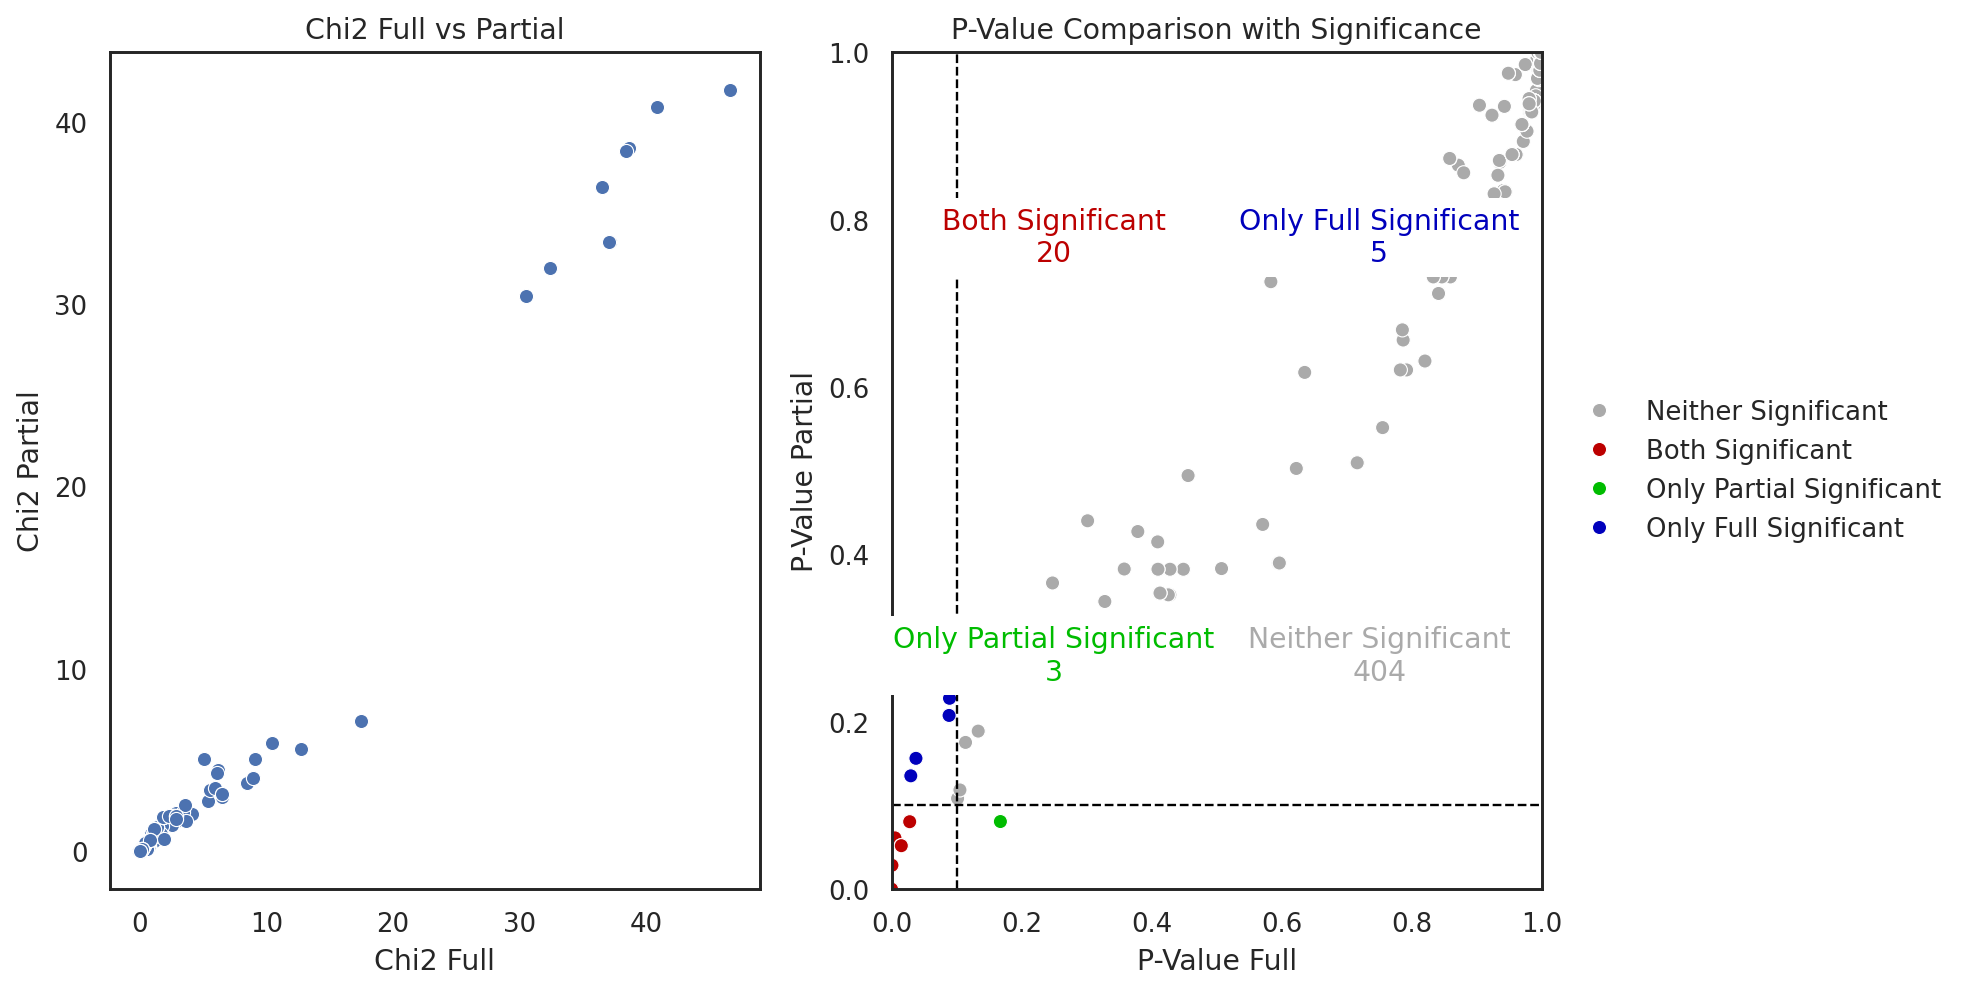

In [27]:
# Add significance categories based on p-value thresholds
alpha = 0.1 

df_pass_chi2_stats['significance'] = df_pass_chi2_stats.apply(
    lambda row: (
        'Both Significant' if row['p_value_full'] < alpha and row['p_value_partial'] < alpha else
        'Only Full Significant' if row['p_value_full'] < alpha else
        'Only Partial Significant' if row['p_value_partial'] < alpha else
        'Neither Significant'
    ),
    axis=1
)

# Count points in each quadrant
quadrant_counts = {
    'Both Significant': len(df_pass_chi2_stats[(df_pass_chi2_stats['p_value_full'] < alpha) & (df_pass_chi2_stats['p_value_partial'] < alpha)]),
    'Only Full Significant': len(df_pass_chi2_stats[(df_pass_chi2_stats['p_value_full'] < alpha) & (df_pass_chi2_stats['p_value_partial'] >= alpha)]),
    'Only Partial Significant': len(df_pass_chi2_stats[(df_pass_chi2_stats['p_value_full'] >= alpha) & (df_pass_chi2_stats['p_value_partial'] < alpha)]),
    'Neither Significant': len(df_pass_chi2_stats[(df_pass_chi2_stats['p_value_full'] >= alpha) & (df_pass_chi2_stats['p_value_partial'] >= alpha)])
}

# Set up the plots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First plot: chi2_full vs chi2_partial
sns.scatterplot(data=df_pass_chi2_stats, x='chi2_full', y='chi2_partial', ax=axs[0])
axs[0].set_title('Chi2 Full vs Partial')
axs[0].set_xlabel('Chi2 Full')
axs[0].set_ylabel('Chi2 Partial')

# Second plot: p_value_full vs p_value_partial with significance categories
sns.scatterplot(
    data=df_pass_chi2_stats,
    x='p_value_full',
    y='p_value_partial',
    hue='significance',
    palette={
        'Both Significant': '#bc0000',
        'Only Full Significant': '#0000bc',
        'Only Partial Significant': '#00bc00',
        'Neither Significant': '#aaaaaa'
    },
    ax=axs[1]
)

# Add thresholds
axs[1].axhline(alpha, color='black', linestyle='--', linewidth=1)
axs[1].axvline(alpha, color='black', linestyle='--', linewidth=1)

# Annotate quadrant counts
axs[1].text(0.25, 0.75, f"Both Significant\n{quadrant_counts['Both Significant']}", 
            ha='center', color='#bc0000', fontsize=12, bbox=dict(facecolor='white', edgecolor='none'))
axs[1].text(0.75, 0.75, f"Only Full Significant\n{quadrant_counts['Only Full Significant']}", 
            ha='center', color='#0000bc', fontsize=12, bbox=dict(facecolor='white', edgecolor='none'))
axs[1].text(0.25, 0.25, f"Only Partial Significant\n{quadrant_counts['Only Partial Significant']}", 
            ha='center', color='#00bc00', fontsize=12, bbox=dict(facecolor='white', edgecolor='none'))
axs[1].text(0.75, 0.25, f"Neither Significant\n{quadrant_counts['Neither Significant']}", 
            ha='center', color='#aaaaaa', fontsize=12, bbox=dict(facecolor='white', edgecolor='none'))

# Customize the plot
axs[1].set_title('P-Value Comparison with Significance')
axs[1].set_xlabel('P-Value Full')
axs[1].set_ylabel('P-Value Partial')
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)

plt.legend(loc='center right', frameon=False, bbox_to_anchor=(1.65, 0.5))
# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [28]:
df_pass_chi2_stats[df_pass_chi2_stats['significance'] != 'Neither Significant'].sort_values(by=['mode', 'S'])

mode   S           column  chi2_full  p_value_full  chi2_partial  \
7       1   2       ganon_norm     30.477         0.000        30.438   
12      1   3  centrifuge_norm      5.064         0.167         5.032   
31      1   7       ganon_norm     37.082         0.000        33.421   
55      2   2       ganon_norm     30.473         0.000        30.438   
60      2   3  centrifuge_norm      5.062         0.167         5.032   
78      2   7  centrifuge_norm     46.620         0.000        41.727   
79      2   7       ganon_norm     37.046         0.000        33.421   
108     3   3  centrifuge_norm      5.061         0.167         5.032   
109     3   3       ganon_norm     36.467         0.000        36.431   
156     4   3  centrifuge_norm     38.612         0.000        38.576   
157     4   3       ganon_norm     36.467         0.000        36.431   
205     5   3       ganon_norm     40.835         0.000        40.799   
209     5   3        mean_norm      6.513         0.089         2.956   
253     6   3       ganon_norm     40.836         0.000        40.799   
282     6  15  centrifuge_norm      8.454         0.037         3.712   
301     7   3       ganon_norm     40.843         0.000        40.799   
318     7   7  centrifuge_norm     12.768         0.005         5.586   
323     7   7        mean_norm      6.531         0.088         3.144   
329     7  10        mean_norm      6.531         0.088         3.144   
347     8   2        mean_norm      9.109         0.028         5.037   
349     8   3       ganon_norm     40.820         0.000        40.799   
353     8   3        mean_norm      9.109         0.028         5.037   
359     8   4        mean_norm      8.979         0.030         3.999   
397     9   3       ganon_norm     38.413         0.000        38.405   
405     9   4     kraken2_norm     32.370         0.000        31.976   
407     9   4        mean_norm     17.490         0.001         7.116   
421     9  10       ganon_norm     10.471         0.015         5.917   
427     9  15       ganon_norm     10.471         0.015         5.917   

     p_value_partial  precision_diff  recall_diff  f1_diff  \
7              0.000           0.060        0.500    0.498   
12             0.081           0.000        0.183    0.227   
31             0.000          -0.269        0.267    0.001   
55             0.000           0.060        0.500    0.498   
60             0.081           0.000        0.183    0.227   
78             0.000           0.376       -0.233    0.088   
79             0.000          -0.269        0.267    0.001   
108            0.081           0.000        0.183    0.227   
109            0.000           0.061        0.550    0.533   
156            0.000           0.000        0.567    0.547   
157            0.000           0.061        0.550    0.533   
205            0.000           0.062        0.583    0.554   
209            0.228          -0.114        0.000   -0.097   
253            0.000           0.062        0.583    0.554   
282            0.156          -0.125        0.000   -0.109   
301            0.000           0.062        0.583    0.554   
318            0.061          -0.152        0.000   -0.135   
323            0.208           0.102        0.000    0.101   
329            0.208           0.102        0.000    0.101   
347            0.081           0.147        0.000    0.127   
349            0.000           0.062        0.583    0.554   
353            0.081           0.147        0.000    0.127   
359            0.135           0.113        0.000    0.114   
397            0.000           0.051        0.567    0.519   
405            0.000          -0.109        0.400    0.210   
407            0.028           0.147        0.000    0.151   
421            0.052           0.164        0.000    0.136   
427            0.052           0.164        0.000    0.136   

             stats_pass0         stats_pass2              significance  
7      [11, 49,

As we see, using a second pass generally does not significantly change the assignment of TP/FP/FN | TN.

In the cases where it changes, the f1-score generally improves, either by increasing the number of TP (by reducing the amount of FN) or reduces the amount of false positives.

Therefore, looking at nominal info **choosing pass2 is the best option**.

## Checking at the correlation between the read counts

Now we are going to check the proportion of reads that are correctly assigned to gold truth species. For that we are goin two show: 
- A correlation plot with pass0 and pass2 reads. We are also going to calculate the correlation between pass0 / pass2 and the expected counts.

In [29]:
df_numerical_stats

pass  mode    profiler  \
0       0     1  centrifuge   
1       0     1       ganon   
2       0     1       kaiju   
3       0     1     kraken2   
4       0     1  krakenuniq   
..    ...   ...         ...   
103     2     9       ganon   
104     2     9       kaiju   
105     2     9     kraken2   
106     2     9  krakenuniq   
107     2     9        mean   

                                           diff_counts  ME_counts  MAE_counts  \
0    [-21.76736, -50.1056, -74.39946666666667, -58....    -16.939      17.173   
1    [-23.91328, -55.785066666666665, -83.386666666...    -28.729      28.729   
2    [-53.25664, -79.21386666666666, -91.4437333333...    -49.543      49.543   
3    [-76.07584, -94.63306666666666, -99.4, -99.609...    -65.147      65.147   
4    [-19.62944, -48.239466666666665, -68.408533333...    -16.729      17.018   
..                                                 ...        ...         ...   
103  [3.88512, -35.4976, -56.00053333333334, -32.8,...     -1.882      18.223   
104  [-48.45856, -76.704, -89.0208, -85.9616, -80.8...    -43.474      43.474   
105  [-39.60768, -84.74186666666667, -95.9482666666...    -32.087      32.087   
106  [-19.67168, -48.3264, -68.4816, -54.56, -41.30...    -16.778      17.064   
107  [-20.390584802138655, -49.665829444940506, -66...    -16.259      16.933   

     MAED_counts  MACV_counts  corr_counts  R2_counts  \
0         23.505        1.369        0.635      0.576   
1         21.022        0.732        0.558      0.590   
2         28.481        0.575        0.389      0.313   
3         24.902        0.382        0.176      0.122   
4         23.765        1.396        0.642      0.572   
..           ...          ...          ...        ...   
103       14.940        0.820        0.751      0.659   
104       29.718        0.684        0.422      0.324   
105       35.514        1.107        0.419      0.235   
106       23.782        1.394        0.641      0.572   
107       21.171        1.250        0.638      0.622   

                                          taxid_counts  \
0    [817, 823, 853, 1304, 1532, 1547, 1579, 1681, ...   
1    [817, 823, 853, 1304, 1532, 1547, 1579, 1681, ...   
2    [817, 823, 853, 1304, 1532, 1547, 1579, 1681, ...   
3    [817, 823, 853, 1304, 1532, 1547, 1579, 1681, ...   
4    [817, 823, 853, 1304, 1532, 1547, 1579, 1681, ...   
..                                                 ...   
103  [817, 823, 853, 1304, 1532, 1547, 1579, 1681, ...   
104  [817, 823, 853, 1304, 1532, 1547, 1579, 1681, ...   
105  [817, 823, 853, 1304, 1532, 1547, 1579, 1681, ...   
106  [817, 823, 853, 1304, 1532, 1547, 1579, 1681, ...   
107  [817, 823, 853, 1304, 1532, 1547, 1579, 1681, ...   

                                        species_counts  \
0    [Bacteroides fragilis, Parabacteroides distaso...   
1    [Bacteroides fragilis, Parabacteroides distaso...   
2    [Bacteroides fragilis, Parabacteroides distaso...   
3    [Bacteroides fragilis, Parabacteroides distaso...   
4    [Bacteroides fragilis, Parabacteroides distaso...   
..                                                 ...   
103  [Bacteroides fragilis, Parabacteroides distaso...   
104  [Bacteroides fragilis, Parabacteroides distaso...   
105  [Bacteroides fragilis, Parabacteroides distaso...   
106  [Bacteroides fragilis, Parabacteroides distaso...   
107  [Bacteroides fragilis, Parabacteroides distaso...   

                                       expected_counts  \
0    [312500, 187500, 187500, 125000, 312500, 12500...   
1    [312500, 187500, 187500, 125000, 312500, 12500...   
2    [312500, 187500, 187500, 125000, 312500, 12500...   
3    [312500, 187500, 187500, 125000, 312500, 12500...   
4    [312500, 187500, 187500, 125000, 312500, 12500...   
..                                                 ...   
103  [312500, 187500, 187500, 125000, 312500, 12500...   
104  [312500, 187500, 187500, 125000, 312500, 12500...   
105  [312500, 187500, 187500, 125000, 312500, 12500...   


In [30]:
# Filter for pass=0 and pass=2
df_pass_0 = df_numerical_stats[df_numerical_stats['pass'] == 0].set_index(['mode', 'profiler'])
df_pass_2 = df_numerical_stats[df_numerical_stats['pass'] == 2].set_index(['mode', 'profiler'])

# Align the two DataFrames to ensure consistent indexing
aligned_df = pd.concat([df_pass_0, df_pass_2], axis=1, keys=['pass0', 'pass2'])

# Extract relevant columns and observed counts for pass=0 and pass=2
comparison_df = aligned_df[['pass0', 'pass2']].apply(
    lambda x: pd.Series({
        'passn': 'comparison',  # Mark as comparison for clarity
        'mode': x.name[0],
        'profiler': x.name[1],
        'taxid_counts': x['pass0']['taxid_counts'],  # Keep consistent metadata
        'expected_counts': x['pass0']['expected_counts'],
        'pass0_counts': x['pass0']['observed_counts'],
        'pass2_counts': x['pass2']['observed_counts'],
        'pass0_MAE': x['pass0']['MAE_counts'],
        'pass0_diff': x['pass0']['diff_counts'],
        'pass2_MAE': x['pass2']['MAE_counts'],
        'pass2_diff': x['pass2']['diff_counts'],
    }),
    axis=1
)

# Reset index for the final DataFrame
comparison_df = comparison_df.reset_index(drop=True)

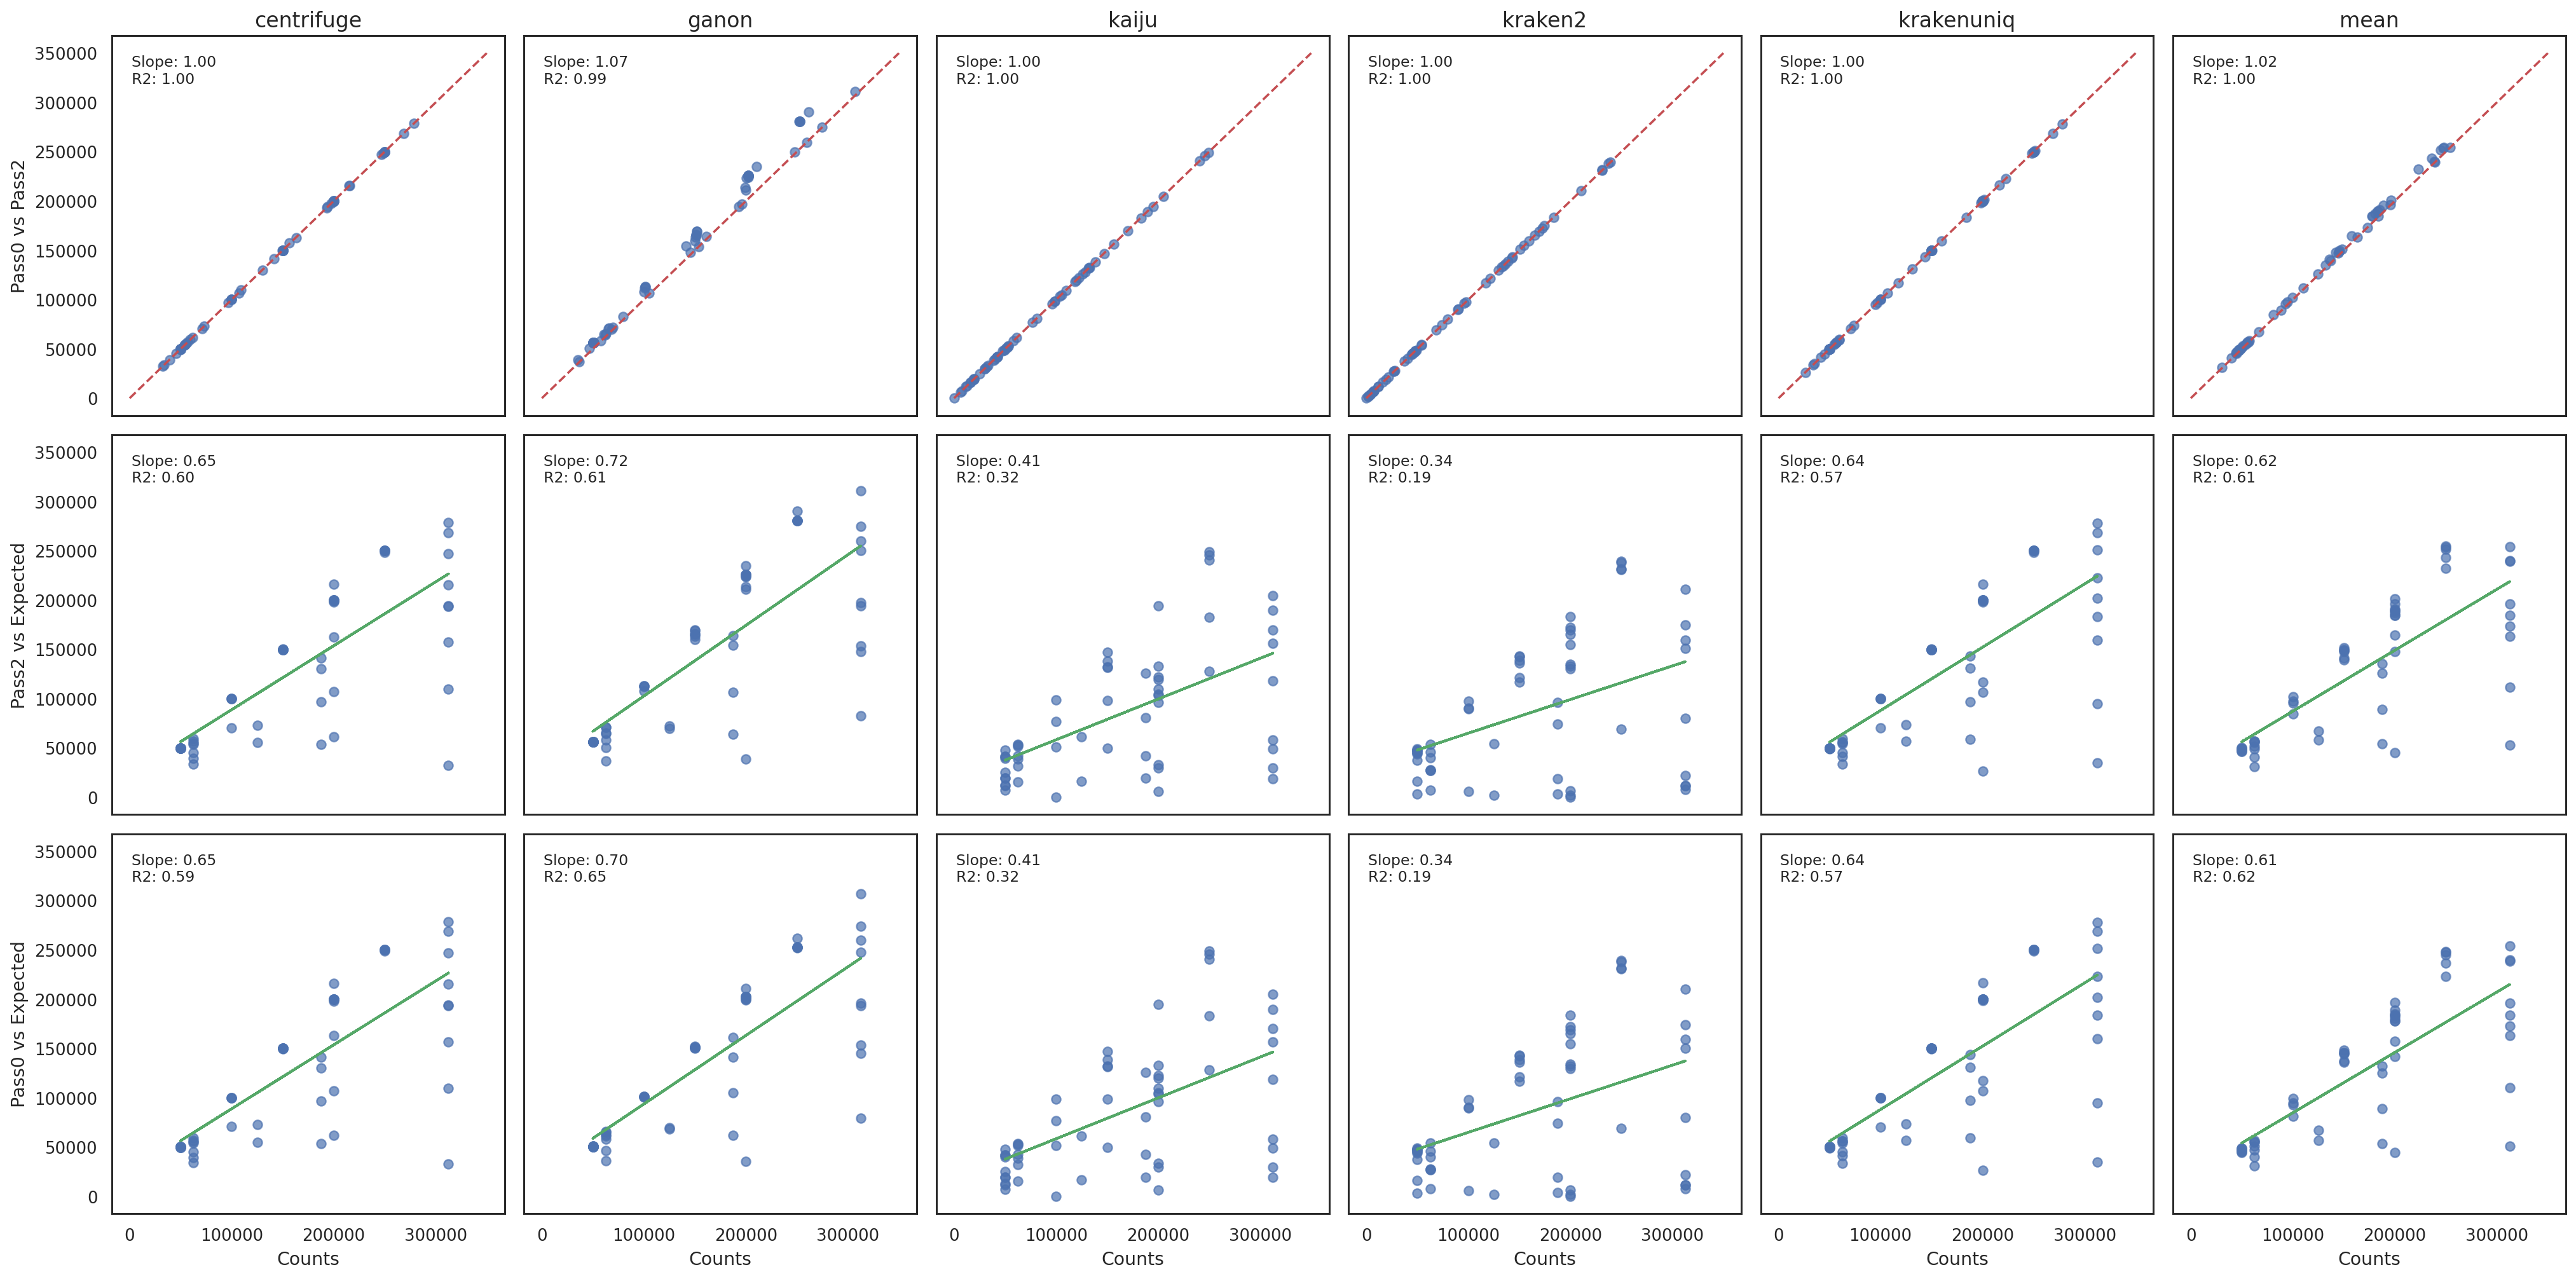

In [31]:
# Filter the DataFrame for the specific mode (5 in this case)
mode_df = comparison_df[comparison_df['mode'] == 5]

# Get unique profilers for layout
profilers = mode_df['profiler'].unique()
num_profilers = len(profilers)

# Set up the figure with GridSpec for custom layout
fig, axs = plt.subplots(3, num_profilers, figsize=(4 * num_profilers, 12), sharex=True, sharey=True)

# Define plotting functions with regression line
def plot_pass0_vs_pass2(ax, data, profiler, i):
    x = data['pass0_counts'].values[0]
    y = data['pass2_counts'].values[0]
    
    # Scatter plot
    ax.scatter(x, y, alpha=0.7)
    
    # Plot y=x line
    min_val, max_val = min(x.min(), y.min()), max(x.max(), y.max())
    ax.plot([0, 350000], [0, 350000], 'r--')
    
    # Pearson correlation and R^2
    slope, intercept, r_value, _, _ = linregress(x, y)
    r2 = r_value ** 2
    ax.annotate(f"Slope: {slope:.2f}\nR2: {r2:.2f}", xy=(0.05, 0.95),
                xycoords='axes fraction', fontsize=10, verticalalignment='top')
    if i == 0:
        ax.set_ylabel("Pass0 vs Pass2", fontsize=12)
    # Set profiler title on top
    ax.set_title(profiler, fontsize=14)

    
def plot_with_regression(ax, x, y, xlabel, i):
    # Scatter plot
    ax.scatter(x, y, alpha=0.7)

    # Regression line
    slope, intercept, r_value, _, _ = linregress(x, y)
    ax.plot(x, slope * x + intercept, 'g-', )

    # Pearson correlation and R^2
    r2 = r_value ** 2
    ax.annotate(f"Slope: {slope:.2f}\nR2: {r2:.2f}", xy=(0.05, 0.95),
                xycoords='axes fraction', fontsize=10, verticalalignment='top')
    if i == 0:
        ax.set_ylabel(xlabel, fontsize=12)

# Iterate through profilers and create subplots for each
for i, profiler in enumerate(profilers):
    profiler_data = mode_df[mode_df['profiler'] == profiler]
    x_pass0 = profiler_data['pass0_counts'].values[0]
    x_expected = profiler_data['expected_counts'].values[0]
    y_pass2 = profiler_data['pass2_counts'].values[0]
    
    # Pass0 vs Pass2 (Row 1)
    ax = fig.add_subplot(axs[0, i])
    plot_pass0_vs_pass2(ax, profiler_data, profiler, i)
    
    # Pass2 vs Expected (Row 2)
    ax = fig.add_subplot(axs[1, i])
    plot_with_regression(ax, x_expected, y_pass2, "Pass2 vs Expected", i)
    
    # Pass0 vs Expected (Row 3)
    ax = fig.add_subplot(axs[2, i])
    plot_with_regression(ax, x_expected, x_pass0, "Pass0 vs Expected", i)


# Aesthetic adjustments
for ax in axs[-1, :]:
    ax.set_xlabel("Counts", fontsize=12)  # Only bottom row has x-labels

plt.tight_layout()
plt.show()



We see that the correlation in number of counts for the ground truth species is almost one. Additionally, if there are differences, they improve the correlation to the expected amount of counts, so it has a positive impact.

## Checking at MAE values

We are going to see if the MAE values are equal or higher in pass2 vs pass0. 

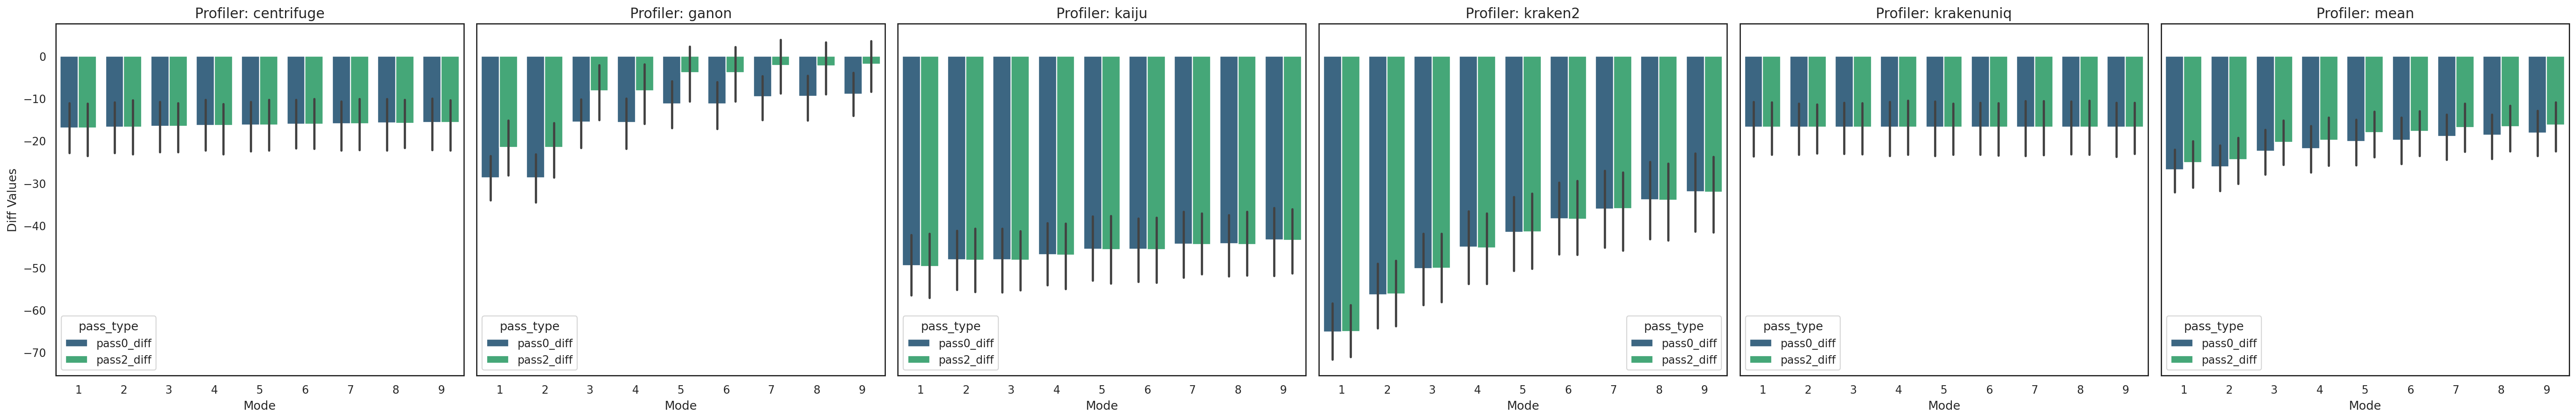

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt


comparison_df_exploded = comparison_df.melt(
    id_vars=['mode', 'profiler'],
    value_vars=['pass0_diff', 'pass2_diff'],
    var_name='pass_type',
    value_name='diff_value'
)

# Convert `diff_value` from a list to separate rows
comparison_df_exploded = comparison_df_exploded.explode('diff_value')

# Ensure `diff_value` is numeric after exploding
comparison_df_exploded['diff_value'] = pd.to_numeric(comparison_df_exploded['diff_value'])




# Get unique profilers
profilers = comparison_df_exploded['profiler'].unique()
num_profilers = len(profilers)

# Set up the figure
fig, axs = plt.subplots(1, num_profilers, figsize=(6 * num_profilers, 6), sharey=True)

# Iterate through profilers and plot the data
for i, profiler in enumerate(profilers):
    ax = axs[i]
    profiler_data = comparison_df_exploded[comparison_df_exploded['profiler'] == profiler]

    # Create the plot
    sns.barplot(
        data=profiler_data,
        x='mode',
        y='diff_value',
        hue='pass_type',
        ax=ax,
        palette='viridis'
    )
    
    # Set plot title and labels
    ax.set_title(f'Profiler: {profiler}', fontsize=14)
    ax.set_xlabel('Mode', fontsize=12)
    if i == 0:
        ax.set_ylabel('Diff Values', fontsize=12)
    else:
        ax.set_ylabel('')

# Adjust layout and display
plt.tight_layout()
plt.show()


We see that, again, the differences in MAE are not due to the pass, with the exception of ganon (and mean by extension), where running the data with pass2 improves the error rate. 

Thus, **both based on nominal and numerical criteria, running with pass2 is the best option**.

# Which mode is best for the data?

We have used several modes to study how it affects the detection of species, and the number of reads it detects. We are going to use the same methods as before to check for the answer.
- We are going to check which mode (using S=2 and S=7) retains the best F1 scores.
- We are going to check which mode keeps the best correlation / MAE with expected counts.

## Checking F1-scores

In [33]:
df_nominal_stats_sub = df_nominal_stats[(df_nominal_stats['pass'] == 2) & (df_nominal_stats['S'].isin([2, 7, 15])) & (df_nominal_stats['column'].isin([f'{i}_norm' for i in LIST_PROFILERS + ['mean']]))]

In [34]:
df_nominal_stats_sub

pass  mode   S           column  precision  recall    f1  kappa  \
1288     2     1   2  centrifuge_norm      1.000   0.050 0.095  0.094   
1289     2     1   2       ganon_norm      0.976   0.683 0.804  0.801   
1290     2     1   2       kaiju_norm      0.792   0.950 0.864  0.861   
1291     2     1   2     kraken2_norm      0.980   0.833 0.901  0.899   
1292     2     1   2  krakenuniq_norm      1.000   0.067 0.125  0.123   
...    ...   ...  ..              ...        ...     ...   ...    ...   
2507     2     9  15       ganon_norm      0.617   0.967 0.753  0.752   
2508     2     9  15       kaiju_norm      0.533   0.950 0.683  0.681   
2509     2     9  15     kraken2_norm      0.891   0.950 0.919  0.919   
2510     2     9  15  krakenuniq_norm      0.400   0.967 0.566  0.563   
2516     2     9  15        mean_norm      0.310   0.967 0.470  0.466   

              TP|FN|FP|TN  
1288     (3, 57, 0, 3522)  
1289    (41, 19, 1, 3521)  
1290    (57, 3, 15, 3507)  
1291    (50, 10, 1, 3521)  
1292     (4, 56, 0, 3522)  
...                   ...  
2507   (58, 2, 36, 12333)  
2508   (57, 3, 50, 12319)  
2509    (57, 3, 7, 12362)  
2510   (58, 2, 87, 12282)  
2516  (58, 2, 129, 12240)  

[162 rows x 9 columns]

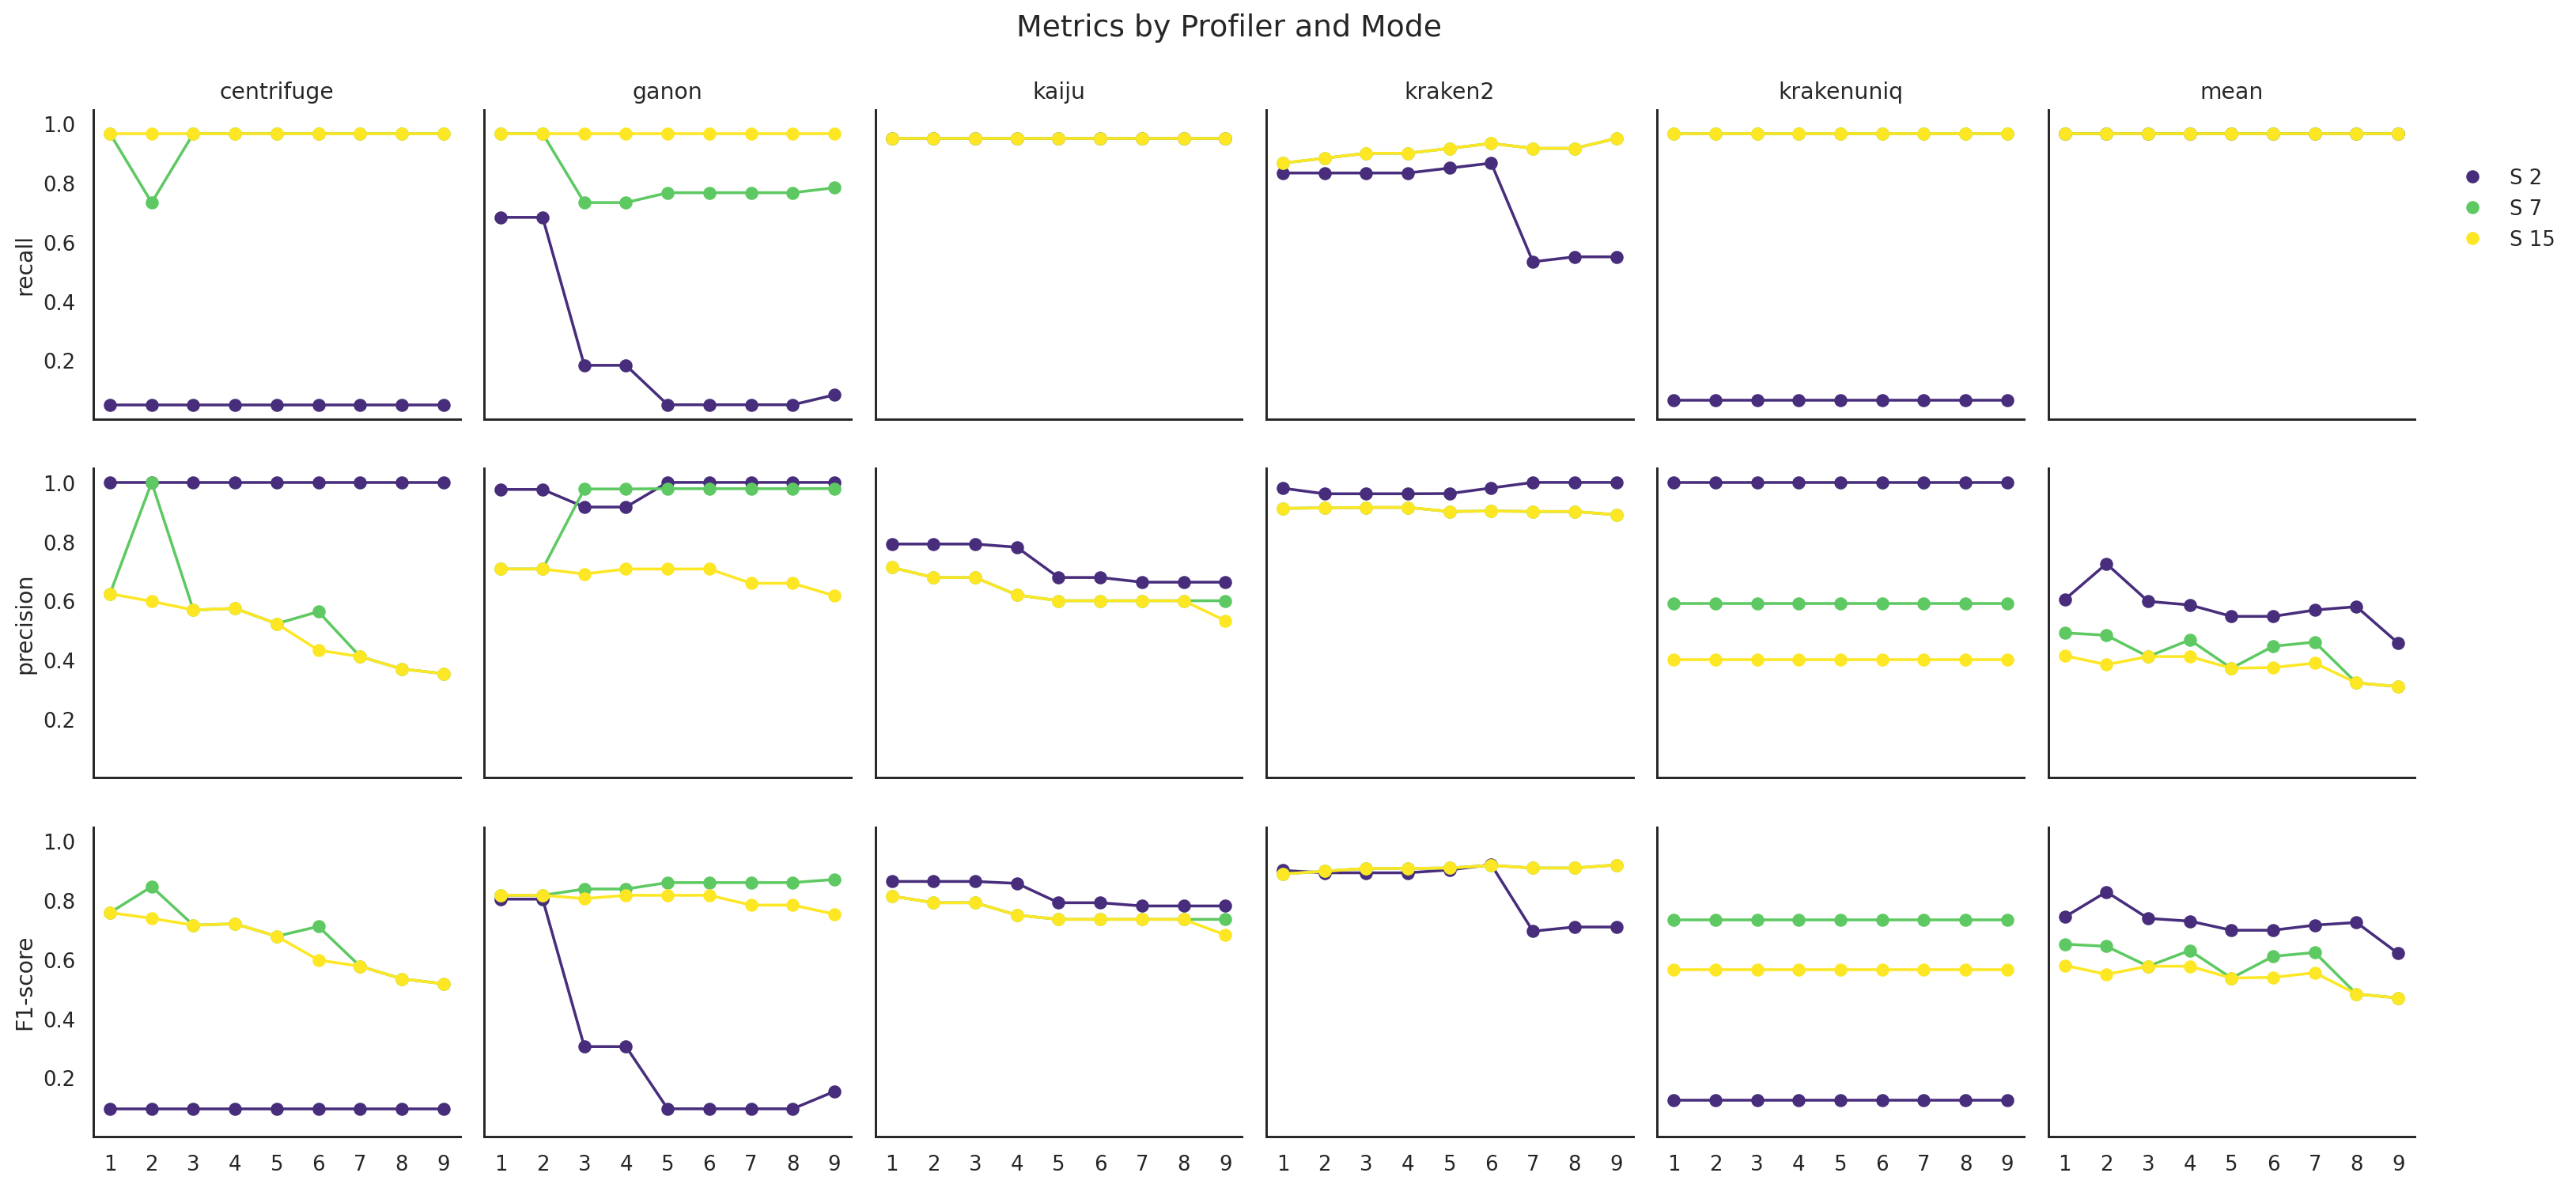

In [35]:
melted_df = pd.melt(
    df_nominal_stats_sub,
    id_vars=['mode', 'S', 'column'],
    value_vars=['recall', 'precision', 'f1'],
    var_name='metric',
    value_name='score'
)

# Create a colormap for 'mode'
norm = Normalize(vmin=melted_df['mode'].min(), vmax=melted_df['mode'].max())
cmap = plt.cm.viridis  # Choose a colormap (e.g., 'viridis', 'plasma', 'cividis')

# Create a FacetGrid: 6x3 grid (row for each profiler, column for each metric)
g = sns.FacetGrid(
    melted_df, 
    col='column', 
    row='metric', 
    height=3, 
    sharey=True, 
    sharex=True
)

# Map the lineplot to the grid
def lineplot_with_cmap(data, **kwargs):
    for S in sorted(data['S'].unique()):
        subset = data[data['S'] == S]
        plt.plot(subset['mode'], subset['score'], label=f"Mode {mode}",
                 color=cmap(norm(S)), marker='o')

g.map_dataframe(lineplot_with_cmap)

# Create a legend for the discrete modes
handles = [
    plt.Line2D([0], [0], color=cmap(norm(mode)), marker='o', linestyle='', label=f"S {mode}")
    for mode in sorted(melted_df['S'].unique())
]
plt.legend(
    handles=handles, 
    title="", 
    bbox_to_anchor=(1.05, 3), 
    loc='center left', 
    frameon=False
)

# Set x-axis ticks (if you have specific S values)
g.set(xticks=df_nominal_stats_sub['mode'].unique())

for ax in g.axes.ravel():
    ax.set_title('')

# Add axis labels and titles
for ax, profiler in zip(g.axes[0, :], melted_df['column'].unique()):
    ax.set_title(profiler.replace('_norm', ''))

for ax, score in zip(g.axes[:, 0], ['recall', 'precision', 'F1-score']):
    ax.set_ylabel(score)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Metrics by Profiler and Mode", fontsize=16)

plt.show()

Based on the table of truth, the precision, recall and f1-score are more S-dependent than mode-dependent; and their patterns are more profiler dependent than anything else. Therefore, the mode is not completely relevant for a proper species detection and, if so, since higher mode values lead to a lower precision (more FP), we could consider using a lower mode if we want to minimize the FPs values. 

## Checking correlation and MAE values

In [36]:
df_numerical_stats_sub = df_numerical_stats[(df_numerical_stats['pass'] == 2) & (df_numerical_stats['mode'].isin([1, 3, 5, 7, 9]))]

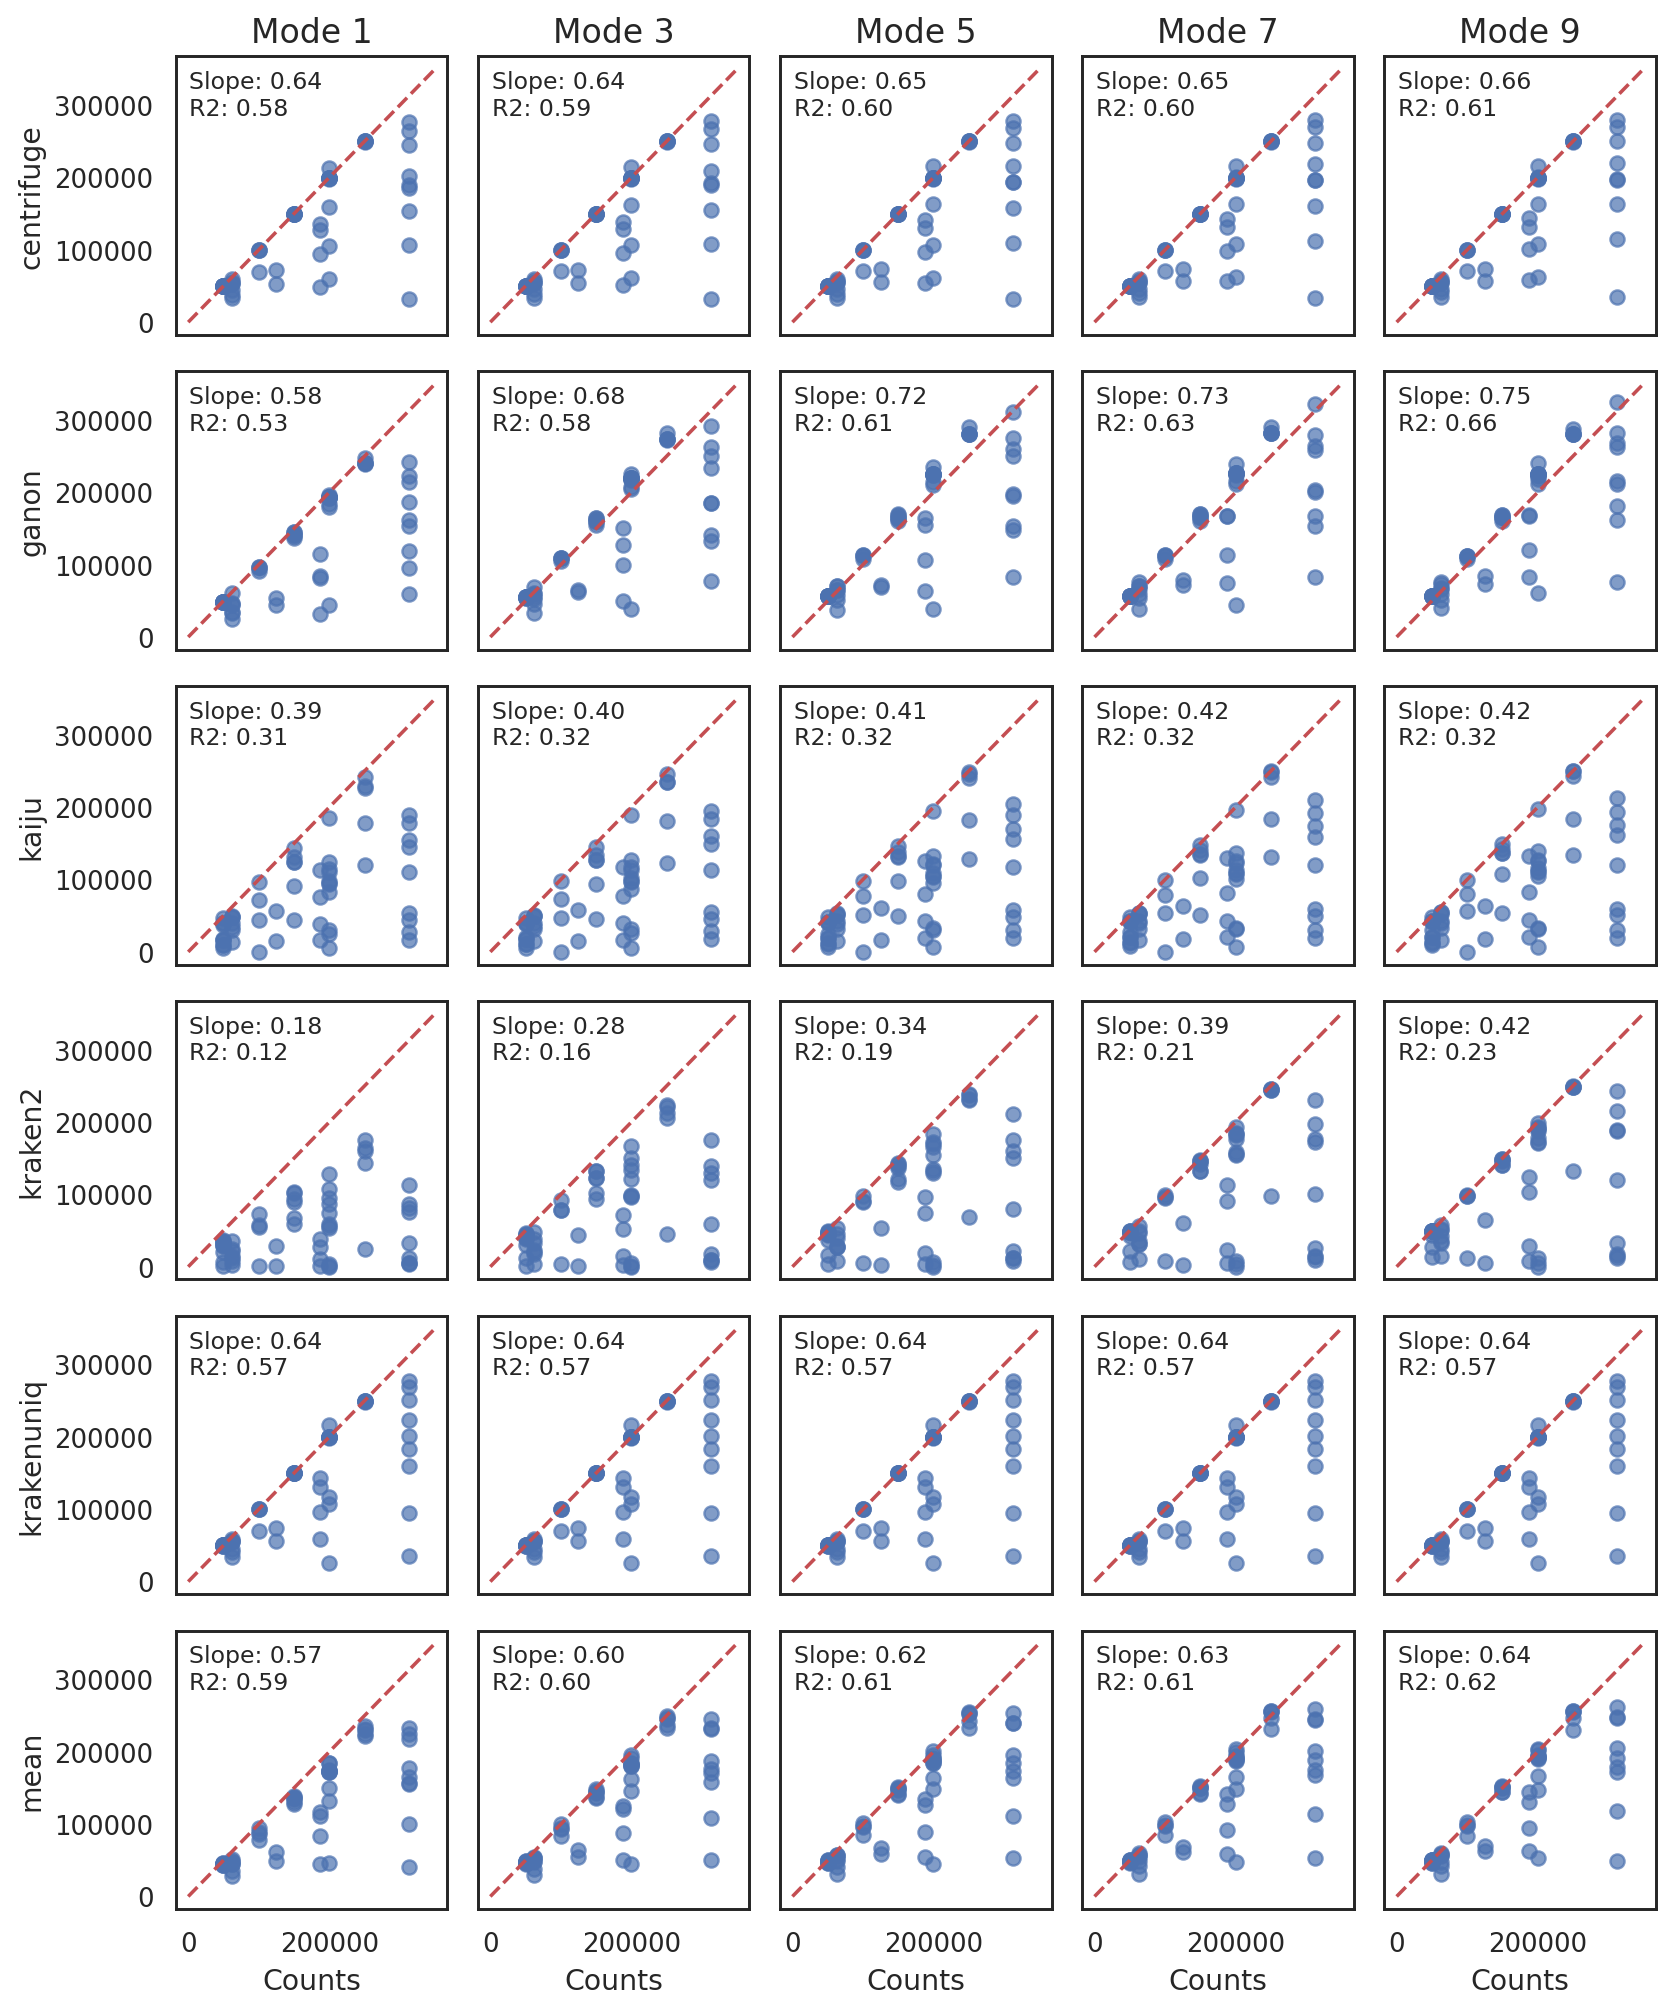

In [37]:
# Get unique profilers for layout
profilers = df_numerical_stats_sub['profiler'].unique()
modes = df_numerical_stats_sub['mode'].unique()


# Set up the figure with GridSpec for custom layout
fig, axs = plt.subplots(len(profilers), len(modes), figsize=(2 *  len(modes), 2* len(profilers)), sharex=True, sharey=True)

# Define plotting functions with regression line
def plot_regression(ax, data, profiler, i):
    x = data['expected_counts'].values[0]
    y = data['observed_counts'].values[0]
    
    # Scatter plot
    ax.scatter(x, y, alpha=0.7)
    
    # Plot y=x line
    min_val, max_val = min(x.min(), y.min()), max(x.max(), y.max())
    ax.plot([0, 350000], [0, 350000], 'r--')
    
    # Pearson correlation and R^2
    slope, intercept, r_value, _, _ = linregress(x, y)
    r2 = r_value ** 2
    ax.annotate(f"Slope: {slope:.2f}\nR2: {r2:.2f}", xy=(0.05, 0.95),
                xycoords='axes fraction', fontsize=10, verticalalignment='top')
    

# Iterate through profilers and create subplots for each
for i, profiler in enumerate(profilers):
    for j, mode in enumerate(modes):
        profiler_data = df_numerical_stats_sub[(df_numerical_stats_sub['profiler'] == profiler) & (df_numerical_stats_sub['mode'] == mode)]
        
        # Pass0 vs Pass2 (Row 1)
        ax = fig.add_subplot(axs[i, j])
        plot_regression(ax, profiler_data, profiler, i)

        if j == 0:
            ax.set_ylabel(profiler, fontsize=12)
            # Set profiler title on top
        if i == 0:
            ax.set_title(f'Mode {mode}', fontsize=14)

# Aesthetic adjustments
for ax in axs[-1, :]:
    ax.set_xlabel("Counts", fontsize=12)  # Only bottom row has x-labels

plt.tight_layout()
plt.show()



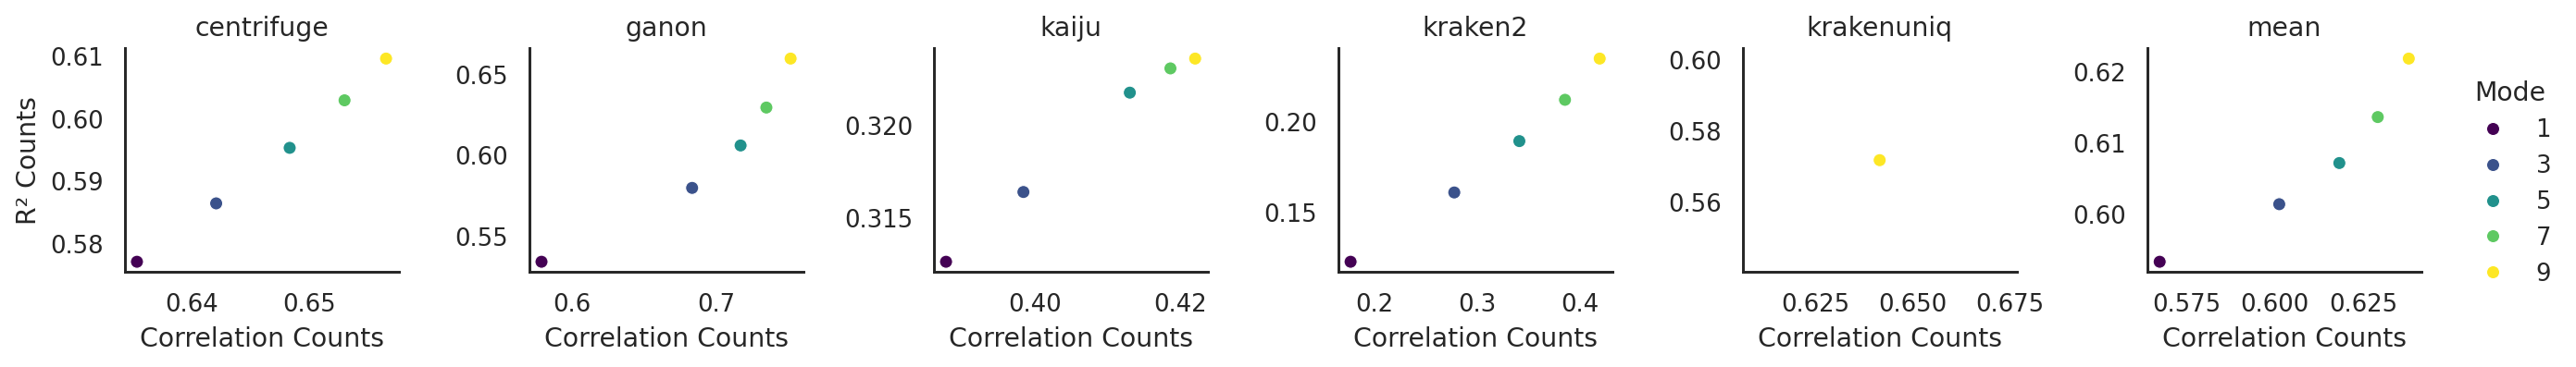

In [38]:
# Initialize the grid of plots with seaborn
g = sns.FacetGrid(df_numerical_stats_sub, col="profiler", height=2.5, aspect=1, sharex=False, sharey=False)

# Plot the data on each facet
g.map_dataframe(
    sns.scatterplot,
    x="corr_counts",
    y="R2_counts",
    hue="mode",
    palette="viridis"
)

# Adjust the legend and titles
g.add_legend(title="Mode", bbox_to_anchor=(1.05, 0.5))

g.set_axis_labels("Correlation Counts", "R² Counts")
g.set_titles(col_template="{col_name}")

plt.tight_layout()
plt.show()

/home/alex/Programs/miniconda3/envs/EVs/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/alex/Programs/miniconda3/envs/EVs/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/alex/Programs/miniconda3/envs/EVs/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/alex/Programs/miniconda3/envs/EVs/lib/python3.12/site-package

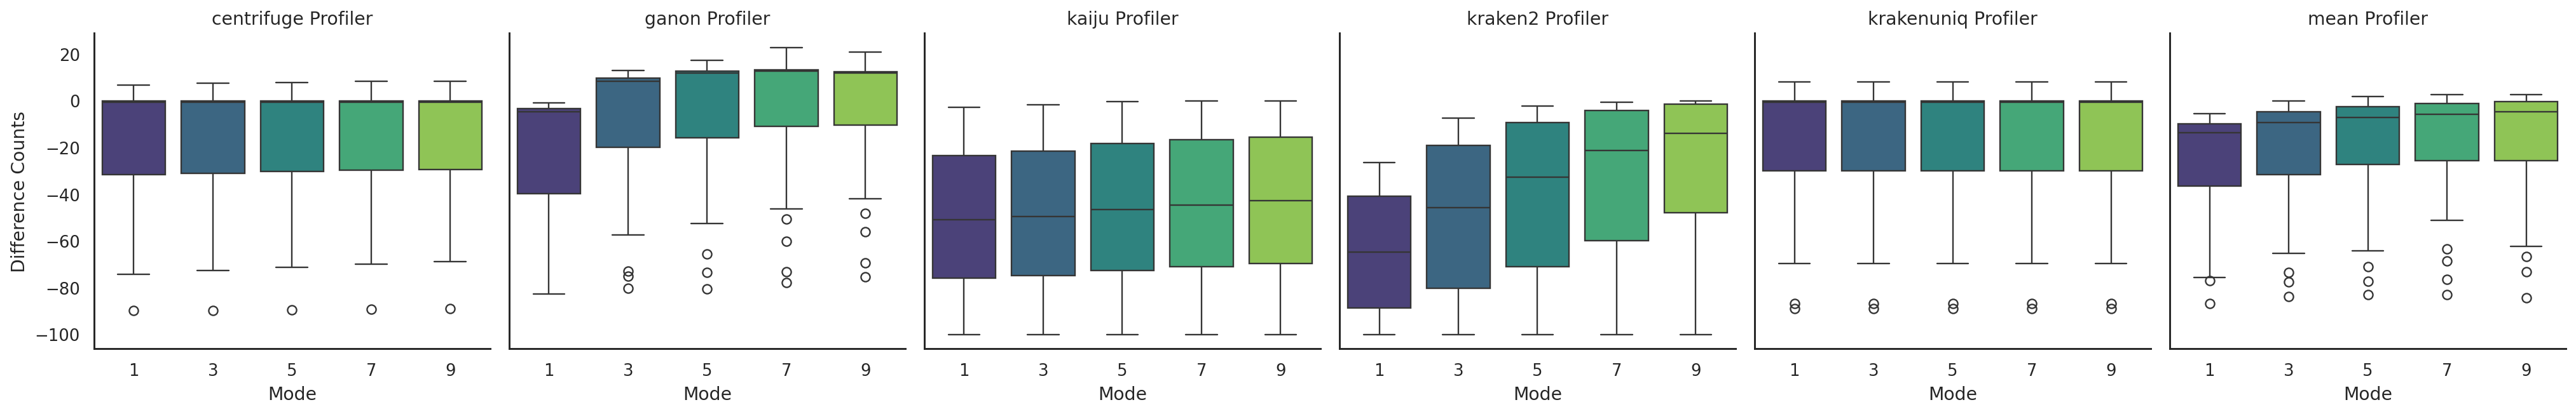

In [39]:
# Prepare the data for plotting
expanded_data = []
for _, row in df_numerical_stats_sub.iterrows():
    profiler = row['profiler']
    mode = row['mode']
    for value in row['diff_counts']:
        expanded_data.append({'profiler': profiler, 'mode': mode, 'diff_counts': value})

# Convert to a new DataFrame
plot_data = pd.DataFrame(expanded_data)

# Initialize the grid of plots with seaborn
g = sns.FacetGrid(plot_data, col="profiler", height=4, aspect=1)

# Plot the data on each facet
g.map_dataframe(
    sns.boxplot,
    x="mode",
    y="diff_counts",
    palette="viridis"
)

# Adjust the legend and titles
g.set_axis_labels("Mode", "Difference Counts")
g.set_titles(col_template="{col_name} Profiler")

plt.tight_layout()
plt.show()

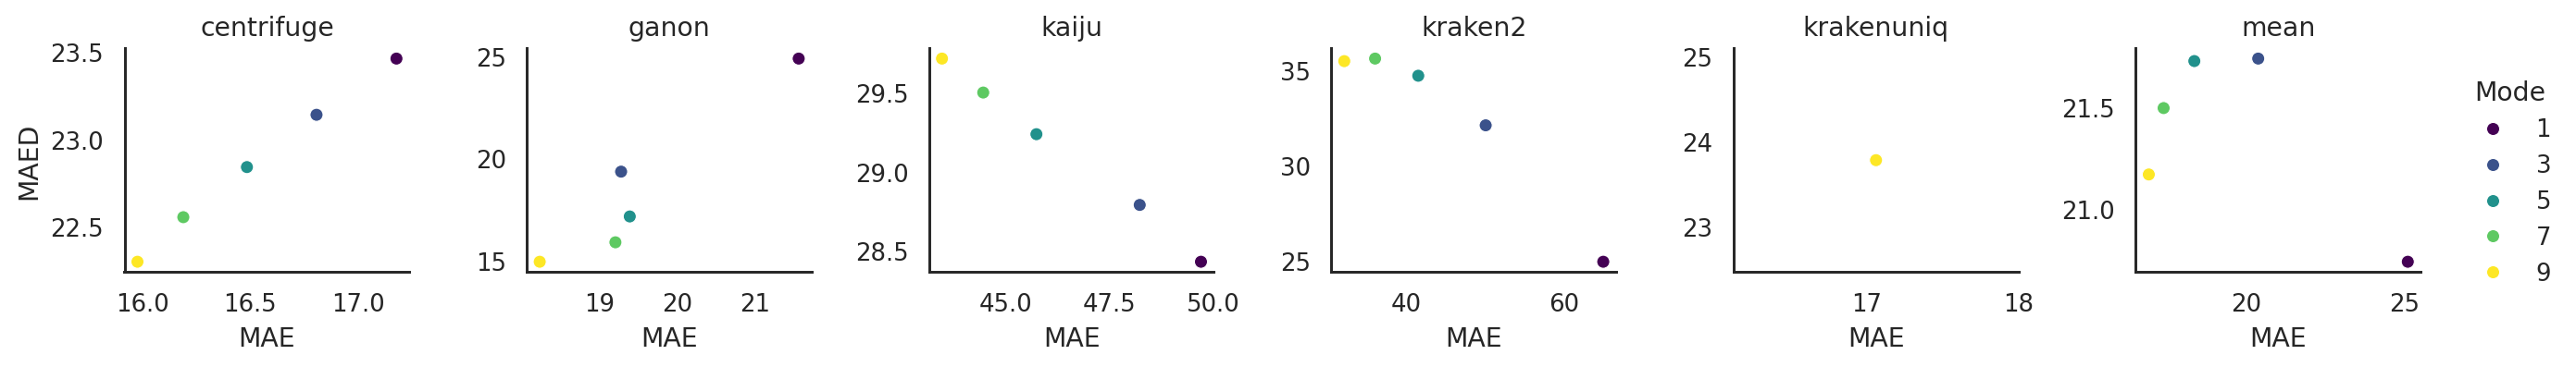

In [40]:
g = sns.FacetGrid(df_numerical_stats_sub, col="profiler", height=2.5, aspect=1, sharex=False, sharey=False)

# Plot the data on each facet
g.map_dataframe(
    sns.scatterplot,
    x="MAE_counts",
    y="MAED_counts",
    hue="mode",
    palette="viridis"
)

# Adjust the legend and titles
g.add_legend(title="Mode", bbox_to_anchor=(1.05, 0.5))

g.set_axis_labels("MAE", "MAED")
g.set_titles(col_template="{col_name}")

plt.tight_layout()
plt.show()

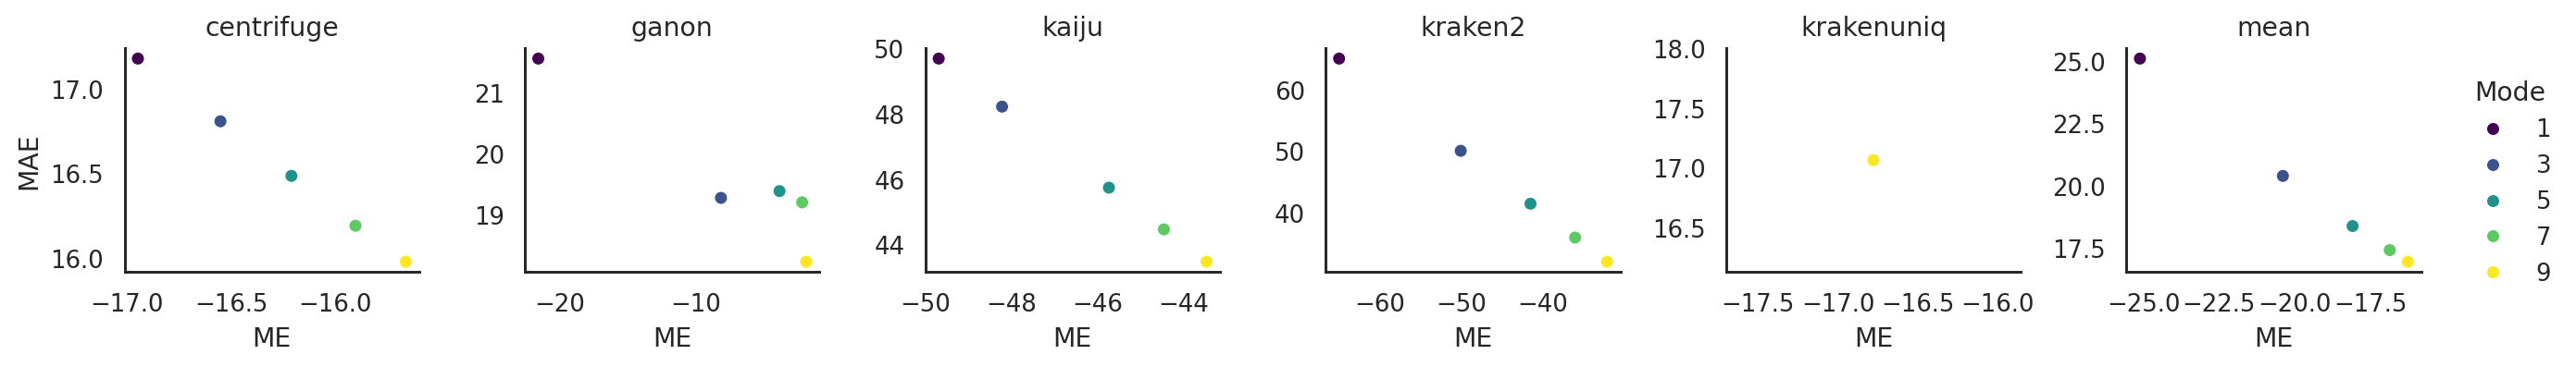

In [41]:
g = sns.FacetGrid(df_numerical_stats_sub, col="profiler", height=2.5, aspect=1, sharex=False, sharey=False)

# Plot the data on each facet
g.map_dataframe(
    sns.scatterplot,
    x="ME_counts",
    y="MAE_counts",
    hue="mode",
    palette="viridis"
)

# Adjust the legend and titles
g.add_legend(title="Mode", bbox_to_anchor=(1.05, 0.5))

g.set_axis_labels("ME", "MAE")
g.set_titles(col_template="{col_name}")

plt.tight_layout()
plt.show()

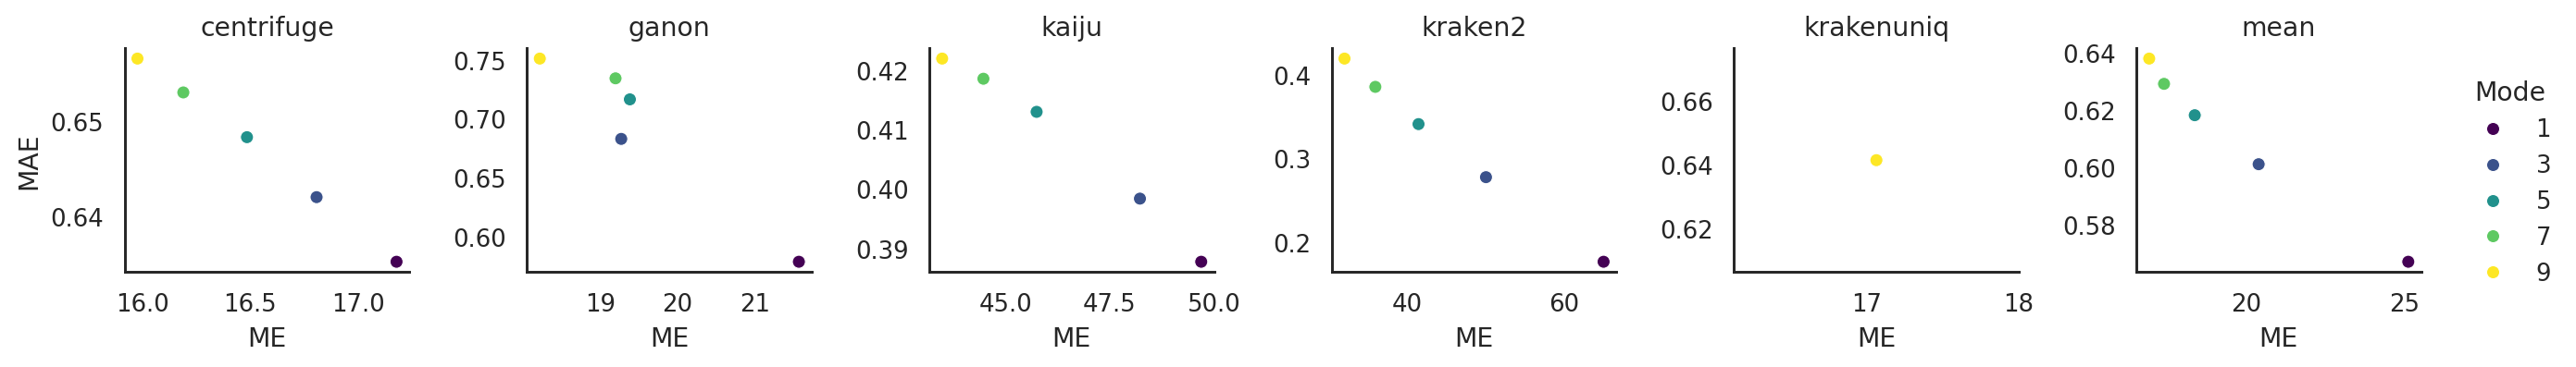

In [42]:
g = sns.FacetGrid(df_numerical_stats_sub, col="profiler", height=2.5, aspect=1, sharex=False, sharey=False)

# Plot the data on each facet
g.map_dataframe(
    sns.scatterplot,
    x="MAE_counts",
    y="corr_counts",
    hue="mode",
    palette="viridis"
)

# Adjust the legend and titles
g.add_legend(title="Mode", bbox_to_anchor=(1.05, 0.5))

g.set_axis_labels("ME", "MAE")
g.set_titles(col_template="{col_name}")

plt.tight_layout()
plt.show()

In [43]:
def plot_prof_couns(df_combo):
    # Assuming your data is in a DataFrame called `df`
    # Expand the diff_counts column into individual rows for plotting
    df_expanded = df_combo.explode('diff_counts')
    df_expanded['diff_counts'] = pd.to_numeric(df_expanded['diff_counts'])

    # Create the plot
    plt.figure(figsize=(10, 2.5))
    sns.stripplot(
        data=df_expanded,
        x='diff_counts',
        y='profiler',
        jitter=True,  # Adds jitter for better visibility of points
        size=5,  # Adjust point size
        alpha=0.7  # Slight transparency
    )

    for profiler, countsdiff in zip(df_combo['profiler'], df_combo['diff_counts']):
        me = np.median(countsdiff)
        med = np.std(countsdiff)
        plt.scatter(me, profiler, color='#aa00bc', label='_nolegend_', s=100, zorder=3, marker = '|')
        plt.plot([me-med, me+med], [profiler, profiler], color='#aa00bc', label='_nolegend_',)


    # Add a vertical line at x=0
    plt.axvline(0, color='red', linestyle='--', linewidth=1)

    # Add labels and title
    # plt.title('Diff Counts Across Profilers', fontsize=14)
    plt.xlabel('Diff Counts', fontsize=12)
    plt.ylabel('Profiler', fontsize=12)
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

3


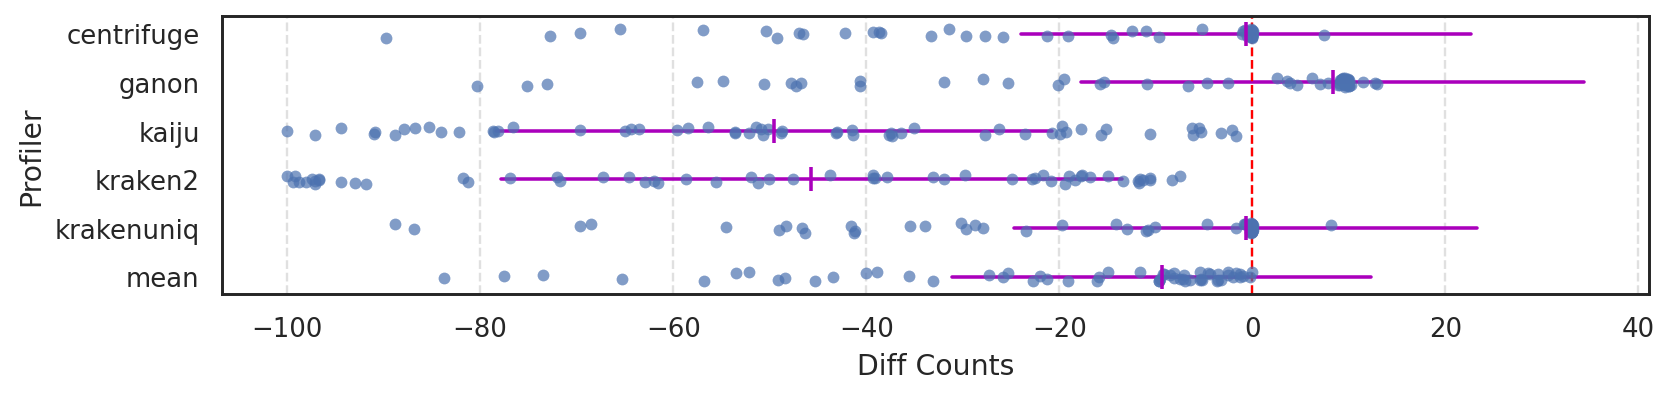

5


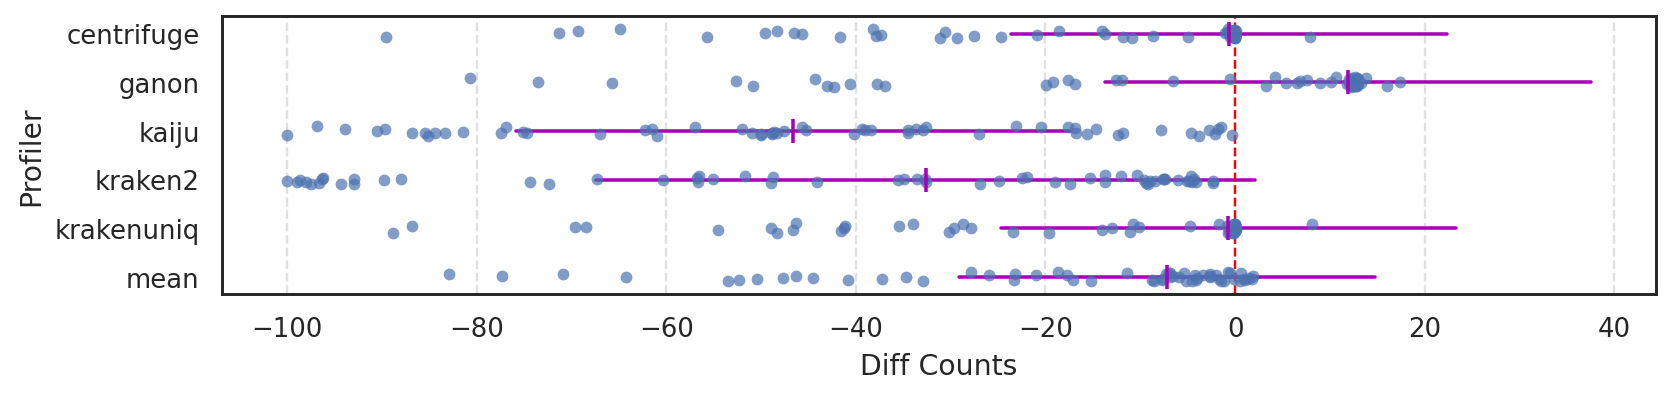

7


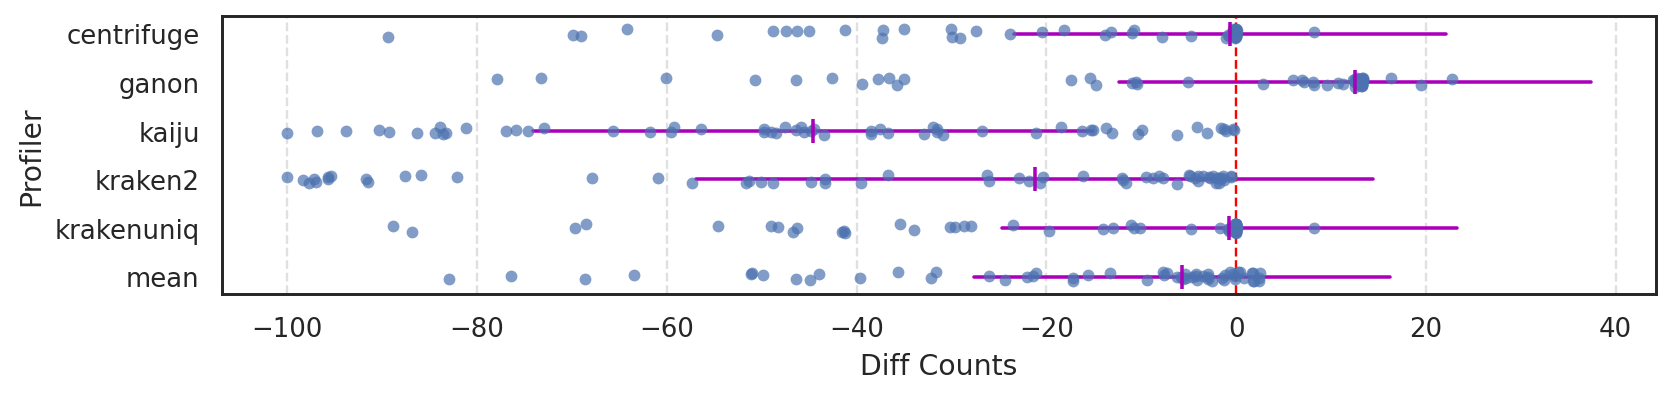

In [44]:
for mode in [3,5,7]:
    print(mode)
    df_combo = df_numerical_stats[(df_numerical_stats['pass'] == 2) & \
                              (df_numerical_stats['mode'] == mode)] # We choose a large number because S in not relevant here (but with small S we may select few datasets)

    plot_prof_couns(df_combo)


Based on these results, we see that a higher mode increases the correlation (slope) and R2; and decreases the MAE (although it increases the MAED). However, again, we see that this effect is very profiler-dependent. It is interesting to note, however, that there are some species that have a very bad detection rate throughout the profiler/mode/S values.

Based on that, considering that higher modes (1) lower the MAE / increase the correlation but (2) decrease the precision; but considering that the effect on (1) is more pronounced that in (2), we are going to choose a high mode value, but not extreme. For instance, `mode = 7`

# Is the mean a good approximation for the different profilers?

Therefore, choosing the mean value is a good option for several reasons:
- In cases where 